In [1]:
############################################################################
#
#     This program is free software; you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation; either version 2, or (at your option)
#   any later version.
#
#   Notebook to implement the Machine Learning model with different
# algorithms.  
#
#   Author: Fernando Burrieza Galan
#
#   Version: 2.5
#
#   Since: 06/05/2022
#
###########################################################################

!pip install elasticsearch7==7.17.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 386 kB 5.1 MB/s 


# Libraries
This section covers the different libraries used in this project. The purpose of each one will be reflected during this notebook.

In [2]:
# Import main Libraries for this notebook
import os
import sys
import time
import pip
import setuptools
import numpy as np
import pandas as pd
from numpy import array
from numpy import argmax
import seaborn as sn
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from elasticsearch7 import Elasticsearch
from elasticsearch7.helpers import scan

In [3]:
# Upload Google Drive Files to the Notebook
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Othercomputers/My Laptop/UC3M 1/4º Year/2º Four Month/TFG/DATA')

Mounted at /content/drive


In [4]:
# Obtain the initial dataframes
dnp3_df = pd.read_csv('dnp3_df_initial.csv')
conn_df = pd.read_csv('conn_df.csv')
packet_filter_df = pd.read_csv('packet_filter_df_initial.csv')
weird_df = pd.read_csv('weird_df_initial.csv')

# Elasticsearch Connection 

This section of the notebook connects Elasticsearch in order to retrieve the indexes of the network traffic in order to make the model.

In [ ]:
# Connect to my ElasticSearch Service
es = Elasticsearch("http://localhost:9200")
es.ping()

False

In [ ]:
# Extract the documents that each index has to convert into a Dataframe
def get_data_from_elastic(index_name):

    # Scan function to get all the data. 
    rel = scan(client=es,                                     
               scroll='1m',
               index=index_name,
               raise_on_error=True,
               preserve_order=False,
               clear_scroll=True)

    # Keep response in a list.
    result = list(rel)

    temp = []

    # We need only '_source', which has all the fields required.
    # This elimantes the elasticsearch metdata like _id, _type, _index.
    for hit in result:
        temp.append(hit['_source'])

    # Create a dataframe.
    df = pd.DataFrame(temp)

    return df

In [ ]:
#  Call to the previous function to obtanthe records of each index
# conn_index = 'zeek_conn_2022-05-06'
# dnp3_index = 'zeek_dnp3_2022-05-06'
# packet_filter_index = 'zeek_packet_filter_2022-05-06'
# weird_index = 'zeek_weird_2022-05-06'

# conn_es_df = get_data_from_elastic(conn_index)
# dnp3_es_df = get_data_from_elastic(dnp3_index)
# packet_filter_es_df = get_data_from_elastic(packet_filter_index)
# weird_es_df = get_data_from_elastic(weird_index)


# Data processing

This section will deal with the data with the purpose of normalization to create a better model.

## Covering datasets faults

Some datasets have errors in the process of converting to a csv file. This subsection transforms the dataframes to deal with data easily

###Conn Dataframe

In [ ]:
# # Assign column names to the dataframe
# conn_df.columns =['index','ts', 'uid', 'id.orig_h',
#                 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service',
#                'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
#                 'local_orig', 'local_resp', 'missed_bytes', 'history',
#                 'orig_pkts', 'orig_ip_bytes', 'orig_ip_bytes', 'resp_pkts',
#                 'resp_ip_bytes']
# conn_df.drop('index', axis=1, inplace=True)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,orig_ip_bytes.1,resp_pkts,resp_ip_bytes
0,1650086752.170552,CYgYyE4y6X1fOgqL8k,192.168.10.66,40833,192.168.10.222,20000,tcp,dnp3_tcp,0.245734,1377.0,...,SF,False,False,0,ShADadFf,7,1749.0,5.0,307.0,NaN
1,1650096002.435371,CJAEzU3R8l7IJm20Oj,192.168.10.221,56575,192.168.10.222,20000,tcp,dnp3_tcp,39.778380,363.0,...,OTH,False,False,0,DTdatATt,74,3767.0,66.0,3443.0,NaN
2,1650103053.208918,CjYeLpo6uzUG6UHHa,192.168.10.221,56575,192.168.10.222,20000,tcp,dnp3_tcp,39.492044,381.0,...,OTH,False,False,0,DTdatAtT,74,3776.0,68.0,3522.0,NaN
3,1650108353.645535,CGtgta1Jtcy5xV3AVe,192.168.10.221,56576,192.168.10.222,20000,tcp,dnp3_tcp,38.134857,363.0,...,OTH,False,False,0,DTdatAT,75,3825.0,68.0,3548.0,NaN
4,1650117722.030642,CXiRTjQ3PvAsdbwe4,192.168.10.221,56577,192.168.10.222,20000,tcp,dnp3_tcp,44.516964,342.0,...,OTH,False,False,0,DTdatATt,70,3547.0,64.0,3353.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,2022-04-16T17:05:36.804183,Cb5OY94SCVq2qahmfb,192.168.10.66,37137,192.168.10.222,20000,tcp,dnp3_tcp,1.515011,324.0,...,RSTO,NaN,NaN,0,SahADdR,11,928.0,NaN,6.0,419.0
1528,2022-04-16T17:10:35.591273,COYIah4hF5wuoBk0X2,192.168.10.66,37140,192.168.10.222,20000,tcp,dnp3_tcp,1.065008,342.0,...,RSTO,NaN,NaN,0,SahADdR,9,842.0,NaN,4.0,271.0
1529,2022-04-16T17:17:33.209194,CZ4HHy32IUMn6lEwG6,192.168.10.66,37147,192.168.10.222,20000,tcp,dnp3_tcp,4.245029,379.0,...,SF,NaN,NaN,0,SahADdFfr,38,2387.0,NaN,28.0,1803.0
1530,2022-04-16T17:26:53.808114,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,tcp,dnp3_tcp,3.225023,364.0,...,RSTO,NaN,NaN,0,SahADdR,37,2320.0,NaN,22.0,1505.0


In [ ]:
# # Save the changes in a new csv file
# conn_df.to_csv('conn_df1.csv', index=False)

In [ ]:
# This dataframe contains more connections apart from DNP3. We are going to drop
# the connections regarding udp and icmp protocol.
print(conn_df['proto'].value_counts(), '\n')
print(conn_df['service'].value_counts(),'\n')
print(conn_df.dtypes)
conn_df

tcp     938467
udp      15316
icmp       406
Name: proto, dtype: int64 

dns               11236
ssl                2596
http               2234
dnp3_tcp            750
modbus              134
krb_tcp              84
ntp                  54
ssh                  46
ftp                  44
dce_rpc              11
smb                  11
modbus,ssl            4
dhcp                  3
modbus,krb_tcp        3
snmp                  2
Name: service, dtype: int64 

ts                 float64
uid                 object
id.orig_h           object
id.orig_p            int64
id.resp_h           object
id.resp_p            int64
proto               object
service             object
duration            object
orig_bytes          object
resp_bytes          object
conn_state          object
local_orig          object
local_resp          object
missed_bytes         int64
history             object
orig_pkts            int64
orig_ip_bytes      float64
orig_ip_bytes.1    float64
resp_pkts          float

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,orig_ip_bytes.1,resp_pkts,resp_ip_bytes
0,1.650078e+09,CESfg9246I76gq3b05,192.168.10.1,138,192.168.10.255,138,udp,NaN,S0,False,...,0,D,1,243,0,0,NaN,NaN,NaN,NaN
1,1.650079e+09,CuUfZNVjK8CO8JPvb,192.168.10.1,138,192.168.10.255,138,udp,NaN,S0,False,...,0,D,1,229,0,0,NaN,NaN,NaN,NaN
2,1.650079e+09,ChZeEz2AG8HPH7lr33,192.168.10.1,137,192.168.10.255,137,udp,dns,1.499807,150,...,S0,False,False,0,D,3,234.0,0.0,0.0,NaN
3,1.650079e+09,CHwYWC4ACg6PsZqJV9,192.168.10.1,138,192.168.10.255,138,udp,NaN,S0,False,...,0,D,1,243,0,0,NaN,NaN,NaN,NaN
4,1.650079e+09,CwRap82TxfEmA59pAb,192.168.10.1,138,192.168.10.255,138,udp,NaN,S0,False,...,0,D,1,229,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954184,1.650366e+09,CrkRHVF7Icdy7GlGg,192.168.10.1,137,192.168.10.255,137,udp,dns,1.499572,150,...,S0,False,False,0,D,3,234.0,0.0,0.0,NaN
954185,1.650366e+09,CZCXNH20amiI3mFFt5,192.168.10.1,138,192.168.10.255,138,udp,NaN,S0,False,...,0,D,1,243,0,0,NaN,NaN,NaN,NaN
954186,1.650280e+09,CwehHA4mzA9WQoP5Xb,192.168.10.1,49169,192.168.10.221,23,udp,NaN,86473.034463,276672,...,SF,False,False,0,Dd,8646,518760.0,8646.0,276672.0,NaN
954187,1.650280e+09,CjKecB1PLsU86xMFG2,192.168.10.20,123,255.255.255.255,123,udp,ntp,86477.935016,518352,...,S0,False,False,0,D,10799,820724.0,0.0,0.0,NaN


In [ ]:
# Drop all rows that contains 'udp' or 'icmp' in 'proto' column
conn_df = conn_df[conn_df.proto != 'udp']
conn_df = conn_df[conn_df.proto != 'icmp']
#conn_df.drop(drop_values, inplace = True)
conn_df

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,orig_ip_bytes.1,resp_pkts,resp_ip_bytes
39,1.650087e+09,CwlDcl1YSuzHWWY6I9,192.168.10.66,39383,192.168.10.20,20000,tcp,NaN,S0,False,...,0,S,1,44,0,0,NaN,NaN,NaN,NaN
40,1.650087e+09,CfgpZo2cAqQNqD8rye,192.168.10.66,39383,192.168.10.221,20000,tcp,NaN,S0,False,...,0,S,1,44,0,0,NaN,NaN,NaN,NaN
41,1.650087e+09,CLisk6gzBXbbx3H44,192.168.10.66,39383,192.168.10.185,20000,tcp,NaN,0.000404,0,...,REJ,False,False,0,Sr,1,44.0,1.0,40.0,NaN
42,1.650087e+09,CWqaIR3Avo9A3IFvgf,192.168.10.66,39383,192.168.10.1,20000,tcp,NaN,0.000883,0,...,REJ,False,False,0,Sr,1,44.0,1.0,40.0,NaN
43,1.650087e+09,CxKY5XhtQvGvq5B87,192.168.10.66,39383,192.168.10.222,20000,tcp,NaN,0.001015,0,...,RSTO,False,False,0,ShR,2,84.0,1.0,44.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953128,1.649956e+09,C4tv2M140Wq0baVMzi,247.232.183.88,2947,192.168.0.197,20000,tcp,NaN,3.75,0,...,RSTO,False,False,0,^hR,1,40.0,1.0,44.0,NaN
953129,1.649956e+09,CkxVRm40hLD7RLYld1,106.55.133.6,3095,192.168.0.197,20000,tcp,NaN,3.75,0,...,RSTO,False,False,0,^hR,1,40.0,1.0,44.0,NaN
953130,1.649956e+09,CMiwc33bK6E09liiC3,163.28.233.39,3082,192.168.0.197,20000,tcp,NaN,3.75,0,...,RSTO,False,False,0,^hR,1,40.0,1.0,44.0,NaN
953634,1.650442e+09,CHpdd94QsQSU3nb2di,192.168.10.221,55459,192.168.10.222,20000,tcp,dnp3_tcp,86485.042584,673164,...,OTH,False,False,0,DdAaTtT,59293,3045304.0,38045.0,2221108.0,NaN


In [ ]:
# Now check the number of different services has the dataframe
print("Number of Nan values:", conn_df['service'].isna().sum(),'\n\n')
print(conn_df['service'].value_counts(),'\n')
print(conn_df['duration'].value_counts(),'\n')

# We only want the connections regarding DNP3 protocol
conn_df = conn_df[conn_df.service == 'dnp3_tcp']

Number of Nan values: 932550 


ssl               2596
http              2234
dnp3_tcp           750
modbus             134
krb_tcp             84
ssh                 46
ftp                 44
dce_rpc             11
smb                 11
modbus,ssl           4
modbus,krb_tcp       3
Name: service, dtype: int64 

S0              282065
0.001347         15676
0.001348         12421
0.001346         10928
0.001349          5909
                 ...  
0.111747             1
60.484802            1
80.60915             1
40.360402            1
86485.042584         1
Name: duration, Length: 49164, dtype: int64 



In [ ]:
conn_df.to_csv('conn_df.csv', index=False)
conn_df

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,orig_ip_bytes.1,resp_pkts,resp_ip_bytes
46,1.650087e+09,CYgYyE4y6X1fOgqL8k,192.168.10.66,40833,192.168.10.222,20000,tcp,dnp3_tcp,0.245734,1377,...,SF,False,False,0,ShADadFf,7,1749.0,5.0,307.0,NaN
94,1.650096e+09,CJAEzU3R8l7IJm20Oj,192.168.10.221,56575,192.168.10.222,20000,tcp,dnp3_tcp,39.77838,363,...,OTH,False,False,0,DTdatATt,74,3767.0,66.0,3443.0,NaN
129,1.650103e+09,CjYeLpo6uzUG6UHHa,192.168.10.221,56575,192.168.10.222,20000,tcp,dnp3_tcp,39.492044,381,...,OTH,False,False,0,DTdatAtT,74,3776.0,68.0,3522.0,NaN
157,1.650108e+09,CGtgta1Jtcy5xV3AVe,192.168.10.221,56576,192.168.10.222,20000,tcp,dnp3_tcp,38.134857,363,...,OTH,False,False,0,DTdatAT,75,3825.0,68.0,3548.0,NaN
203,1.650118e+09,CXiRTjQ3PvAsdbwe4,192.168.10.221,56577,192.168.10.222,20000,tcp,dnp3_tcp,44.516964,342,...,OTH,False,False,0,DTdatATt,70,3547.0,64.0,3353.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951648,1.649956e+09,CX2PrA4G5LuCwXDZYd,192.168.0.198,41821,192.168.0.197,20000,tcp,dnp3_tcp,9.0,189,...,SF,False,False,0,ShAdDaFf,23,1393.0,15.0,1571.0,NaN
951649,1.649956e+09,CM657KDQyZLGQnyD7,192.168.0.198,53091,192.168.0.197,20000,tcp,dnp3_tcp,8.25,171,...,SF,False,False,0,ShAdDaFf,21,1271.0,14.0,1502.0,NaN
951650,1.649956e+09,Ch9BgD3AEGAyDlfe9j,192.168.0.198,41660,192.168.0.197,20000,tcp,dnp3_tcp,9.0,189,...,SF,False,False,0,ShAdDaFf,23,1393.0,15.0,1571.0,NaN
953634,1.650442e+09,CHpdd94QsQSU3nb2di,192.168.10.221,55459,192.168.10.222,20000,tcp,dnp3_tcp,86485.042584,673164,...,OTH,False,False,0,DdAaTtT,59293,3045304.0,38045.0,2221108.0,NaN


### DNP3 Dataframe

#### See the features


In [ ]:
# First we eliminate the first columns because they haven't significance to the model
dnp3_df.drop(['zeek_log_filename', 'zeek_log_path', '@timestamp'], axis=1, inplace=True)

# Now we need to format all string variables in this dataframe becasue neural 
# networks only work with integer numbers
# Count the different values that has the columns id.orig_h and id.resp_h

# Check first the number of NaN values of both variables
print("Number of NaN values:", dnp3_df['id.orig_h'].isna().sum(),'\n')
print("Number of Nan values:", dnp3_df['id.resp_h'].isna().sum(),'\n\n')

print(dnp3_df['id.orig_h'].value_counts(), '\n')
print(dnp3_df['id.resp_h'].value_counts(), '\n\n')

print("Number of Nan values (req):", dnp3_df['fc_request'].isna().sum(),'\n')
print("Number of Nan values (res):", dnp3_df['fc_reply'].isna().sum(),'\n\n')

print(dnp3_df['fc_request'].value_counts(),'\n')
print(dnp3_df['fc_reply'].value_counts(),'\n\n')

print("Number of Nan values (iin):", dnp3_df['iin'].isna().sum(),'\n\n')
print("iin:\n", dnp3_df['iin'].value_counts(),'\n')

Number of NaN values: 0 

Number of Nan values: 0 


192.168.10.221    259100
172.16.16.50       17447
192.168.0.198       5555
192.168.1.150        704
10.10.20.5           368
10.0.0.8              66
10.0.0.9              44
127.0.0.1             42
10.42.26.221          18
192.168.66.33         11
192.168.136.91         6
192.168.2.166          3
10.64.96.104           2
Name: id.orig_h, dtype: int64 

192.168.10.222    259100
172.16.16.6        17447
192.168.0.197       5555
192.168.1.200        704
10.10.20.8           368
10.0.0.3             110
127.0.0.1             42
10.42.27.125          18
192.168.66.34         11
192.168.136.93         6
192.168.88.95          3
192.168.10.2           2
Name: id.resp_h, dtype: int64 


Number of Nan values (req): 16303 

Number of Nan values (res): 22 


READ                    247896
CONFIRM                  12447
WRITE                     2920
RECORD_CURRENT_TIME       2900
ENABLE_UNSOLICITED         554
SELECT                     145
O

#### Indexing IP Strings to Int

In [ ]:
# ASSIGN THE CATEGORY TO id.orig_h
list_id_orig_h = dnp3_df['id.orig_h']
id_orig_h = dnp3_df['id.orig_h'].value_counts()
id_orig_h_cat = pd.DataFrame(id_orig_h)
id_orig_h_cat.reset_index(inplace=True)
id_orig_h_cat.columns = ['IP', 'Count']
id_orig_h_cat = id_orig_h_cat.assign(Category = [1, 2, 3, 4, 5, 6, 6, 7, 8, 9,  
                                                10, 11, 12])
# Create a Dictionary with IP and Category
id_orig_h_serie = dict(zip(id_orig_h_cat.IP, id_orig_h_cat.Category))

# Assign the new categories
dnp3_df['id.orig_h_index'] = dnp3_df['id.orig_h'].map(id_orig_h_serie)

# Create a New dataframe to store the categories of id.resp_h
id_resp_h = dnp3_df['id.resp_h'].value_counts()
id_resp_h_cat = pd.DataFrame(id_resp_h)
id_resp_h_cat.reset_index(inplace=True)
id_resp_h_cat.columns = ['IP', 'Count']
id_resp_h_cat = id_resp_h_cat.assign(Category = [1, 2, 3, 4, 5, 6, 7, 8, 9,  
                                                10, 11, 12])
id_resp_h_serie = dict(zip(id_resp_h_cat.IP, id_resp_h_cat.Category))

# Assign the new categories
dnp3_df['id.resp_h_index'] = dnp3_df['id.resp_h'].map(id_resp_h_serie)

#### INDEXING OPERATIONS TO INT

In [ ]:
# Assign a value to NaN values on fc_request
dnp3_df.fc_request = dnp3_df.fc_request.fillna('NO_OPERATION')

print("Number of Nan values (req):", dnp3_df['fc_request'].isna().sum(),'\n')

# ASSIGN THE CATEGORY TO fc_request
fc_request = dnp3_df['fc_request'].value_counts()
fc_request_cat = pd.DataFrame(fc_request)
fc_request_cat.reset_index(inplace=True)
fc_request_cat.columns = ['Operation', 'Count']
fc_request_cat = fc_request_cat.assign(Category = [1, 2, 3, 4, 5, 6, 7, 8, 9,  
                                                10, 11, 12, 13, 14, 15, 16, 17])
# Create a Dictionary with IP and Category
fc_request_serie = dict(zip(fc_request_cat.Operation, fc_request_cat.Category))

# Assign the new categories
dnp3_df['fc_request_index'] = dnp3_df['fc_request'].map(fc_request_serie)

dnp3_df

Number of Nan values (req): 0 



,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,anomaly,fc_reply,iin,id.orig_h_index,id.resp_h_index,fc_request_index
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,2127,192.168.88.95,20000,DISABLE_UNSOLICITED,0,NaN,NaN,11,11,9
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,2137,192.168.88.95,20000,UNSOLICITED_RESPONSE,0,NaN,NaN,11,11,17
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,2142,192.168.88.95,20000,READ,0,NaN,NaN,11,11,1
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,20001,192.168.10.2,20000,READ,0,RESPONSE,4096.0,12,12,1
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,64825,127.0.0.1,20000,OPERATE,0,NaN,NaN,7,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283361,2022-04-12T08:20:09.750000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1
283362,2022-04-12T08:20:10.250000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1
283363,2022-04-12T08:20:10.500000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,NaN,NaN,4,4,1
283364,2022-04-12T08:18:58.500000,Cd0wDx1AnRKcD0oXae,10.0.0.8,1159,10.0.0.3,20000,DISABLE_UNSOLICITED,0,NaN,NaN,6,6,9


In [ ]:
# Assign a value to NaN values on fc_request
dnp3_df.fc_reply = dnp3_df.fc_reply.fillna('NO_OPERATION')

print("Number of Nan values (res):", dnp3_df['fc_reply'].isna().sum(),'\n')

# ASSIGN THE CATEGORY TO fc_request
fc_reply = dnp3_df['fc_reply'].value_counts()
fc_reply_cat = pd.DataFrame(fc_reply)
fc_reply_cat.reset_index(inplace=True)
fc_reply_cat.columns = ['Operation', 'Count']
fc_reply_cat = fc_reply_cat.assign(Category = [1, 2, 3, 4])
print(fc_reply_cat)
# Create a Dictionary with IP and Category
fc_reply_serie = dict(zip(fc_reply_cat.Operation, fc_reply_cat.Category))

# Assign the new categories
dnp3_df['fc_reply_index'] = dnp3_df['fc_reply'].map(fc_reply_serie)

dnp3_df

Number of Nan values (res): 0 

              Operation   Count  Category
0              RESPONSE  256478         1
1  UNSOLICITED_RESPONSE   26862         2
2          NO_OPERATION      22         3
3                  READ       4         4


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,anomaly,fc_reply,iin,id.orig_h_index,id.resp_h_index,fc_request_index,fc_reply_index
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,2127,192.168.88.95,20000,DISABLE_UNSOLICITED,0,NO_OPERATION,NaN,11,11,9,3
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,2137,192.168.88.95,20000,UNSOLICITED_RESPONSE,0,NO_OPERATION,NaN,11,11,17,3
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,2142,192.168.88.95,20000,READ,0,NO_OPERATION,NaN,11,11,1,3
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,20001,192.168.10.2,20000,READ,0,RESPONSE,4096.0,12,12,1,1
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,64825,127.0.0.1,20000,OPERATE,0,NO_OPERATION,NaN,7,7,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283361,2022-04-12T08:20:09.750000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1,1
283362,2022-04-12T08:20:10.250000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1,1
283363,2022-04-12T08:20:10.500000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,NO_OPERATION,NaN,4,4,1,3
283364,2022-04-12T08:18:58.500000,Cd0wDx1AnRKcD0oXae,10.0.0.8,1159,10.0.0.3,20000,DISABLE_UNSOLICITED,0,NO_OPERATION,NaN,6,6,9,3


In [ ]:
dnp3_df.to_csv('dnp3_df.csv', index = False)

#### Float iin to INT


In [ ]:
dnp3_df = pd.read_csv('dnp3_df.csv')
dnp3_df

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,anomaly,fc_reply,iin,id.orig_h_index,id.resp_h_index,fc_request_index,fc_reply_index
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,2127,192.168.88.95,20000,DISABLE_UNSOLICITED,0,NO_OPERATION,NaN,11,11,8,3
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,2137,192.168.88.95,20000,UNSOLICITED_RESPONSE,0,NO_OPERATION,NaN,11,11,16,3
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,2142,192.168.88.95,20000,READ,0,NO_OPERATION,NaN,11,11,1,3
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,20001,192.168.10.2,20000,READ,0,RESPONSE,4096.0,12,12,1,1
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,64825,127.0.0.1,20000,OPERATE,0,NO_OPERATION,NaN,7,7,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283361,2022-04-12T08:20:09.750000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1,1
283362,2022-04-12T08:20:10.250000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1,1
283363,2022-04-12T08:20:10.500000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,NO_OPERATION,NaN,4,4,1,3
283364,2022-04-12T08:18:58.500000,Cd0wDx1AnRKcD0oXae,10.0.0.8,1159,10.0.0.3,20000,DISABLE_UNSOLICITED,0,NO_OPERATION,NaN,6,6,8,3


In [ ]:
# Assign a value to NaN values on fc_request
dnp3_df.iin = dnp3_df.iin.fillna(0.0)

print("Number of Nan values (res):", dnp3_df['fc_reply'].isna().sum(),'\n')

# ASSIGN THE CATEGORY TO fc_request
iin = dnp3_df['iin'].value_counts()
iin_cat = pd.DataFrame(iin)
iin_cat.reset_index(inplace=True)
iin_cat.columns = ['Msg_Size', 'Count']
iin_cat = iin_cat.assign(Category = range(1,len(iin_cat['Msg_Size'])+1))
print(iin_cat)

# Create a Dictionary with IP and Category
iin_cat_serie = dict(zip(iin_cat.Msg_Size, iin_cat.Category))

# Assign the new categories
dnp3_df['iin_index'] = dnp3_df['iin'].map(iin_cat_serie)

dnp3_df


Number of Nan values (res): 0 

    Msg_Size   Count  Category
0        0.0  255477         1
1     4096.0   11031         2
2     1024.0   10132         3
3     4097.0    2874         4
4     4100.0    2870         5
5     6144.0     624         6
6      512.0     218         7
7    32768.0      35         8
8     6145.0      30         9
9     6148.0      30        10
10       1.0      13        11
11   36864.0       6        12
12    8192.0       6        13
13       4.0       5        14
14       6.0       5        15
15   15364.0       2        16
16   15362.0       2        17
17     256.0       2        18
18   38145.0       2        19
19   38920.0       1        20
20   38912.0       1        21


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,anomaly,fc_reply,iin,id.orig_h_index,id.resp_h_index,fc_request_index,fc_reply_index,iin_index
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,2127,192.168.88.95,20000,DISABLE_UNSOLICITED,0,NO_OPERATION,0.0,11,11,8,3,1
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,2137,192.168.88.95,20000,UNSOLICITED_RESPONSE,0,NO_OPERATION,0.0,11,11,16,3,1
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,2142,192.168.88.95,20000,READ,0,NO_OPERATION,0.0,11,11,1,3,1
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,20001,192.168.10.2,20000,READ,0,RESPONSE,4096.0,12,12,1,1,2
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,64825,127.0.0.1,20000,OPERATE,0,NO_OPERATION,0.0,7,7,7,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283361,2022-04-12T08:20:09.750000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1,1,1
283362,2022-04-12T08:20:10.250000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1,1,1
283363,2022-04-12T08:20:10.500000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,NO_OPERATION,0.0,4,4,1,3,1
283364,2022-04-12T08:18:58.500000,Cd0wDx1AnRKcD0oXae,10.0.0.8,1159,10.0.0.3,20000,DISABLE_UNSOLICITED,0,NO_OPERATION,0.0,6,6,8,3,1


#### Weird Log

In [ ]:
weird_df.drop(['zeek_log_filename', 'zeek_log_path', '@timestamp'], axis=1, inplace=True)

In [ ]:
print("Number of Nan values (Name):", weird_df['name'].isna().sum(),'\n\n')
print("Number of Nan values (source):", weird_df['source'].isna().sum(),'\n\n')
print("Number of Nan values (addl):", weird_df['addl'].isna().sum(),'\n\n')


print(weird_df['addl'].value_counts(), '\n')
print(weird_df['source'].value_counts(),'\n')
print(weird_df['name'].value_counts(),'\n')

weird_df = weird_df[weird_df.source =='DNP3_TCP']

Number of Nan values (Name): 0 


Number of Nan values (source): 282 


Number of Nan values (addl): 2212 


SSH-2.0-moxa_1.0 vs SSH-1.5-Nmap-SSH1-Hostkey       16
SSH-2.0-OpenSSH_4.0 vs SSH-1.5-Nmap-SSH1-Hostkey     8
SSH-2.0-OpenSSH_4.0 vs SSH-1.5-NmapNSE_1.0           8
SSH-2.0-Mocana SSH  vs SSH-1.5-Nmap-SSH1-Hostkey     8
SSH-2.0-Mocana SSH  vs SSH-1.5-NmapNSE_1.0           8
SSH-2.0-moxa_1.0 vs SSH-1.5-NmapNSE_1.0              8
t3                                                   3
SSH-2.0-moxa_1.0 vs HELP                             2
Name: addl, dtype: int64 

TCP            839
DNP3_TCP       588
HTTP           404
CONTENTLINE    157
NVT              3
Name: source, dtype: int64 

dnp3_header_lacks_magic           585
SYN_with_data                     402
bad_HTTP_request                  378
window_recision                   219
line_terminated_with_single_CR    157
TCP_ack_underflow_or_misorder     118
TCP_seq_underflow_or_misorder      70
active_connection_reuse           

In [ ]:
print(weird_df['uid'].value_counts(), '\n')
print(dnp3_df['uid'].value_counts(), '\n')

CZMNgE17Kgi6RM1j66    1
CVuvdnYQhwBGYArl      1
CxtzCo4l0ATkbY9GWb    1
CBdGPM3tOz1t4vv4Uh    1
Cb8LQ43UyYQg6h4ne2    1
                     ..
C23Hf41WbCRhbM2Lwi    1
Cxpk9Kf4BFDQ9MOI3     1
CKuLN64AlmcJLBN5Dj    1
CDiKr54XTkBrlsNZ1e    1
CEqxQV26A8OF11fsI2    1
Name: uid, Length: 588, dtype: int64 

CHpdd94QsQSU3nb2di    32403
ChX8QV2WUUv0rf4T88    32403
CCOriv4rDc4xjXU2j     32395
CCJgLe1jWP6JnE9ks5    32395
CfcMEN3Jc4o4xowyb2    32379
                      ...  
C9wG7B2O0qOBcDcje1        1
Clb2zWavHA6RfB9ql         1
C96fZ648iC6Z0x8Yte        1
CTys3H3MIXLtiHjv7k        1
CDPLXV1J6t2QLI3Gg1        1
Name: uid, Length: 624, dtype: int64 



In [ ]:
# Save in csv the final dataframe 
weird_df.to_csv('weird_df.csv', index=False)

#### Add anomaly values to DNP3_df

In [ ]:
# Extract the number of coincidences between the values of 2 columns
test_weird = weird_df['uid'].tolist()

test_dnp3 = dnp3_df['uid'].tolist()

results = {}

# Check number of occurrences that share both columns

for i in test_weird:
  results[i] = test_dnp3.count(i)


In [ ]:
# Iterate through this dict to eliminate all uid that don't match with dnp3
results = list(results.items())

results = [i for i in results if i[1] != 0]

results

[('CD36SZ6bAMITPqyHb', 1),
 ('CGEaHN1TGiFTDT1qy2', 12),
 ('Cw2ml51GVqvAUPZ9y1', 8),
 ('CEFe754uJcD8GlFhqa', 8),
 ('CMyQRm2pi6APKUWSK6', 8),
 ('CIavEB11ucm8caBQZ9', 8),
 ('CsIEa54EnLtNEAw29i', 8),
 ('Cp4LMT1TMgS8taDswe', 13),
 ('CZxrYyg421iFGjBn1', 3),
 ('CPuUCy3hKm6Ao7MA8f', 1),
 ('CMNEme4g5lqDQ5ltGh', 3),
 ('CEqxQV26A8OF11fsI2', 1)]

In [ ]:
# Assign the uid from result list to add the anomaly number

result = dict(results)
# Change the value for each key 
for key, value in result.items():
        result[key] = 1
result
# Assign the new categories
dnp3_df['anomaly'] = dnp3_df['uid'].map(result)
dnp3_df 

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,anomaly,fc_reply,iin,id.orig_h_index,id.resp_h_index,fc_request_index,fc_reply_index
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,2127,192.168.88.95,20000,DISABLE_UNSOLICITED,NaN,NO_OPERATION,NaN,11,11,9,3
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,2137,192.168.88.95,20000,UNSOLICITED_RESPONSE,1.0,NO_OPERATION,NaN,11,11,17,3
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,2142,192.168.88.95,20000,READ,NaN,NO_OPERATION,NaN,11,11,1,3
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,20001,192.168.10.2,20000,READ,NaN,RESPONSE,4096.0,12,12,1,1
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,64825,127.0.0.1,20000,OPERATE,NaN,NO_OPERATION,NaN,7,7,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283361,2022-04-12T08:20:09.750000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,NaN,RESPONSE,0.0,4,4,1,1
283362,2022-04-12T08:20:10.250000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,NaN,RESPONSE,0.0,4,4,1,1
283363,2022-04-12T08:20:10.500000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,NaN,NO_OPERATION,NaN,4,4,1,3
283364,2022-04-12T08:18:58.500000,Cd0wDx1AnRKcD0oXae,10.0.0.8,1159,10.0.0.3,20000,DISABLE_UNSOLICITED,NaN,NO_OPERATION,NaN,6,6,9,3


In [ ]:
dnp3_df = dnp3_df.fillna({'anomaly': 0})

dnp3_df['anomaly'] = dnp3_df['anomaly'].astype(int)
print(dnp3_df['anomaly'].value_counts())

0    283292
1        74
Name: anomaly, dtype: int64


In [ ]:
dnp3_df

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,anomaly,fc_reply,iin,id.orig_h_index,id.resp_h_index,fc_request_index,fc_reply_index
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,2127,192.168.88.95,20000,DISABLE_UNSOLICITED,0,NO_OPERATION,NaN,11,11,9,3
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,2137,192.168.88.95,20000,UNSOLICITED_RESPONSE,1,NO_OPERATION,NaN,11,11,17,3
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,2142,192.168.88.95,20000,READ,0,NO_OPERATION,NaN,11,11,1,3
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,20001,192.168.10.2,20000,READ,0,RESPONSE,4096.0,12,12,1,1
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,64825,127.0.0.1,20000,OPERATE,0,NO_OPERATION,NaN,7,7,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283361,2022-04-12T08:20:09.750000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1,1
283362,2022-04-12T08:20:10.250000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1,1
283363,2022-04-12T08:20:10.500000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,NO_OPERATION,NaN,4,4,1,3
283364,2022-04-12T08:18:58.500000,Cd0wDx1AnRKcD0oXae,10.0.0.8,1159,10.0.0.3,20000,DISABLE_UNSOLICITED,0,NO_OPERATION,NaN,6,6,9,3


## Process New Datasets


In [ ]:
# Load new dataframes
dnp3_df2 = pd.read_csv('dnp3_df_2.csv')
conn_df2 = pd.read_csv('conn_df_2.csv')
weird_df2 = pd.read_csv('weird_df_2.csv')

### Conn Dataset

In [ ]:
# Eliminate columns that have no significance
conn_df2.drop(['zeek_log_filename', 'zeek_log_path', '@timestamp'], axis=1, inplace=True)

KeyError: ignored

In [ ]:
# Drop all rows that contains 'udp' or 'icmp' in 'proto' column
conn_df2 = conn_df2[conn_df2.proto != 'udp']
conn_df2 = conn_df2[conn_df2.proto != 'icmp']
conn_df2

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
0,2022-04-15T13:31:39.406113,Ce9QsB4ABbJFWzGSC1,192.168.10.66,39591,192.168.10.222,20000,tcp,dnp3_tcp,0.180002,1026.0,35.0,SF,0,ShADadFf,7,1398,5,307
1,2022-04-15T13:35:36.662773,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,tcp,dnp3_tcp,1.305009,324.0,223.0,RSTO,0,SahADdR,16,1188,11,807
2,2022-04-15T13:33:02.311693,CdlXVv2jnqswS2Chwl,192.168.10.66,39592,192.168.10.222,20000,tcp,dnp3_tcp,12.240086,69065.0,0.0,S1,0,SahAD,282,83761,279,14520
3,2022-04-15T13:34:38.402365,CsSj6e1GRHP7kBgBB2,192.168.10.66,39595,192.168.10.222,20000,tcp,dnp3_tcp,12.210086,65502.0,0.0,S1,0,SahAD,290,80614,287,14936
4,2022-04-15T13:40:43.189916,CND5pU1FriBCA1O2k,192.168.10.66,39604,192.168.10.222,20000,tcp,dnp3_tcp,1.200009,342.0,253.0,RSTR,0,SahADdfr,17,1258,15,1033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,2022-04-16T17:05:36.804183,Cb5OY94SCVq2qahmfb,192.168.10.66,37137,192.168.10.222,20000,tcp,dnp3_tcp,1.515011,324.0,95.0,RSTO,0,SahADdR,11,928,6,419
778,2022-04-16T17:10:35.591273,COYIah4hF5wuoBk0X2,192.168.10.66,37140,192.168.10.222,20000,tcp,dnp3_tcp,1.065008,342.0,51.0,RSTO,0,SahADdR,9,842,4,271
779,2022-04-16T17:17:33.209194,CZ4HHy32IUMn6lEwG6,192.168.10.66,37147,192.168.10.222,20000,tcp,dnp3_tcp,4.245029,379.0,347.0,SF,0,SahADdFfr,38,2387,28,1803
780,2022-04-16T17:26:53.808114,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,tcp,dnp3_tcp,3.225023,364.0,349.0,RSTO,0,SahADdR,37,2320,22,1505


In [ ]:
# Now check the number of different services has the dataframe
print("Number of Nan values:", conn_df2['service'].isna().sum(),'\n\n')
print(conn_df2['service'].value_counts(),'\n')
print(conn_df2['duration'].value_counts(),'\n')

# We only want the connections regarding DNP3 protocol
conn_df2 = conn_df2[conn_df2.service == 'dnp3_tcp']
conn_df2

Number of Nan values: 0 


dnp3_tcp    782
Name: service, dtype: int64 

0.045000     99
0.045001     45
0.090001     19
0.105001     13
0.090000     12
             ..
49.170344     1
93.255652     1
0.930006      1
45.240316     1
3.225023      1
Name: duration, Length: 451, dtype: int64 



,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
0,2022-04-15T13:31:39.406113,Ce9QsB4ABbJFWzGSC1,192.168.10.66,39591,192.168.10.222,20000,tcp,dnp3_tcp,0.180002,1026.0,35.0,SF,0,ShADadFf,7,1398,5,307
1,2022-04-15T13:35:36.662773,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,tcp,dnp3_tcp,1.305009,324.0,223.0,RSTO,0,SahADdR,16,1188,11,807
2,2022-04-15T13:33:02.311693,CdlXVv2jnqswS2Chwl,192.168.10.66,39592,192.168.10.222,20000,tcp,dnp3_tcp,12.240086,69065.0,0.0,S1,0,SahAD,282,83761,279,14520
3,2022-04-15T13:34:38.402365,CsSj6e1GRHP7kBgBB2,192.168.10.66,39595,192.168.10.222,20000,tcp,dnp3_tcp,12.210086,65502.0,0.0,S1,0,SahAD,290,80614,287,14936
4,2022-04-15T13:40:43.189916,CND5pU1FriBCA1O2k,192.168.10.66,39604,192.168.10.222,20000,tcp,dnp3_tcp,1.200009,342.0,253.0,RSTR,0,SahADdfr,17,1258,15,1033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,2022-04-16T17:05:36.804183,Cb5OY94SCVq2qahmfb,192.168.10.66,37137,192.168.10.222,20000,tcp,dnp3_tcp,1.515011,324.0,95.0,RSTO,0,SahADdR,11,928,6,419
778,2022-04-16T17:10:35.591273,COYIah4hF5wuoBk0X2,192.168.10.66,37140,192.168.10.222,20000,tcp,dnp3_tcp,1.065008,342.0,51.0,RSTO,0,SahADdR,9,842,4,271
779,2022-04-16T17:17:33.209194,CZ4HHy32IUMn6lEwG6,192.168.10.66,37147,192.168.10.222,20000,tcp,dnp3_tcp,4.245029,379.0,347.0,SF,0,SahADdFfr,38,2387,28,1803
780,2022-04-16T17:26:53.808114,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,tcp,dnp3_tcp,3.225023,364.0,349.0,RSTO,0,SahADdR,37,2320,22,1505


In [ ]:
# Concat both Dataframes to have the Final one
conn_df = pd.concat([conn_df, conn_df2], ignore_index=True)

In [ ]:
# Save new file as csv
conn_df.to_csv('conn_df.csv', index=False)
conn_df

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,orig_ip_bytes.1,resp_pkts,resp_ip_bytes
0,1650086752.170552,CYgYyE4y6X1fOgqL8k,192.168.10.66,40833,192.168.10.222,20000,tcp,dnp3_tcp,0.245734,1377.0,...,SF,False,False,0,ShADadFf,7,1749.0,5.0,307.0,NaN
1,1650096002.435371,CJAEzU3R8l7IJm20Oj,192.168.10.221,56575,192.168.10.222,20000,tcp,dnp3_tcp,39.778380,363.0,...,OTH,False,False,0,DTdatATt,74,3767.0,66.0,3443.0,NaN
2,1650103053.208918,CjYeLpo6uzUG6UHHa,192.168.10.221,56575,192.168.10.222,20000,tcp,dnp3_tcp,39.492044,381.0,...,OTH,False,False,0,DTdatAtT,74,3776.0,68.0,3522.0,NaN
3,1650108353.645535,CGtgta1Jtcy5xV3AVe,192.168.10.221,56576,192.168.10.222,20000,tcp,dnp3_tcp,38.134857,363.0,...,OTH,False,False,0,DTdatAT,75,3825.0,68.0,3548.0,NaN
4,1650117722.030642,CXiRTjQ3PvAsdbwe4,192.168.10.221,56577,192.168.10.222,20000,tcp,dnp3_tcp,44.516964,342.0,...,OTH,False,False,0,DTdatATt,70,3547.0,64.0,3353.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2309,2022-04-16T17:05:36.804183,Cb5OY94SCVq2qahmfb,192.168.10.66,37137,192.168.10.222,20000,tcp,dnp3_tcp,1.515011,324.0,...,RSTO,NaN,NaN,0,SahADdR,11,928.0,NaN,6.0,419.0
2310,2022-04-16T17:10:35.591273,COYIah4hF5wuoBk0X2,192.168.10.66,37140,192.168.10.222,20000,tcp,dnp3_tcp,1.065008,342.0,...,RSTO,NaN,NaN,0,SahADdR,9,842.0,NaN,4.0,271.0
2311,2022-04-16T17:17:33.209194,CZ4HHy32IUMn6lEwG6,192.168.10.66,37147,192.168.10.222,20000,tcp,dnp3_tcp,4.245029,379.0,...,SF,NaN,NaN,0,SahADdFfr,38,2387.0,NaN,28.0,1803.0
2312,2022-04-16T17:26:53.808114,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,tcp,dnp3_tcp,3.225023,364.0,...,RSTO,NaN,NaN,0,SahADdR,37,2320.0,NaN,22.0,1505.0


### DNP3

In [ ]:
dnp3_df2.drop(['zeek_log_filename', 'zeek_log_path', '@timestamp'], axis=1, inplace=True)
print(dnp3_df2['id.orig_h'].value_counts(), '\n')
print(dnp3_df2['id.resp_h'].value_counts(), '\n\n')

print(dnp3_df['id.orig_h'].value_counts(), '\n')
print(dnp3_df['id.resp_h'].value_counts(), '\n\n')

NameError: ignored

In [ ]:
# Assign Integers to IP and DNP3 operations

# ASSIGN THE CATEGORY TO id.orig_h
list_id_orig_h = dnp3_df2['id.orig_h']
id_orig_h = dnp3_df2['id.orig_h'].value_counts()
id_orig_h_cat = pd.DataFrame(id_orig_h)
id_orig_h_cat.reset_index(inplace=True)
id_orig_h_cat.columns = ['IP', 'Count']
id_orig_h_cat = id_orig_h_cat.assign(Category = [1, 13])

# Create a Dictionary with IP and Category
id_orig_h_serie = dict(zip(id_orig_h_cat.IP, id_orig_h_cat.Category))

# Assign the new categories
dnp3_df2['id.orig_h_index'] = dnp3_df2['id.orig_h'].map(id_orig_h_serie)

# Create a New dataframe to store the categories of id.resp_h
id_resp_h = dnp3_df2['id.resp_h'].value_counts()
id_resp_h_cat = pd.DataFrame(id_resp_h)
id_resp_h_cat.reset_index(inplace=True)
id_resp_h_cat.columns = ['IP', 'Count']
id_resp_h_cat = id_resp_h_cat.assign(Category = [1])
id_resp_h_serie = dict(zip(id_resp_h_cat.IP, id_resp_h_cat.Category))

# Assign the new categories
dnp3_df2['id.resp_h_index'] = dnp3_df2['id.resp_h'].map(id_resp_h_serie)
dnp3_df2

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,fc_reply,iin,anomaly,id.orig_h_index,id.resp_h_index
0,2022-04-15T13:31:39.511114,Ce9QsB4ABbJFWzGSC1,192.168.10.66,39591,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1
1,2022-04-15T13:31:39.556114,Ce9QsB4ABbJFWzGSC1,192.168.10.66,39591,192.168.10.222,20000,READ,NaN,NaN,1,13,1
2,2022-04-15T13:35:37.172776,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1
3,2022-04-15T13:35:37.202776,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1
4,2022-04-15T13:35:37.202776,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,NaN,RESPONSE,0.0,1,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...
91171,2022-04-16T17:26:56.478133,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1
91172,2022-04-16T17:26:56.703135,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,CONFIRM,UNSOLICITED_RESPONSE,0.0,1,13,1
91173,2022-04-16T17:26:56.913136,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,NaN,UNSOLICITED_RESPONSE,0.0,1,13,1
91174,2022-04-16T17:33:56.271069,Clo3Nnt8Ore0B8h6c,192.168.10.221,51327,192.168.10.222,20000,NaN,UNSOLICITED_RESPONSE,0.0,1,1,1


In [ ]:
# Do the same with the operations
print("Number of Nan values (res):", dnp3_df2['fc_reply'].isna().sum(),'\n')
print("Number of Nan values (req):", dnp3_df2['fc_request'].isna().sum(),'\n')

dnp3_df2.fc_request = dnp3_df2.fc_request.fillna('NO_OPERATION')
dnp3_df2.fc_reply = dnp3_df2.fc_reply.fillna('NO_OPERATION')

print(dnp3_df2['fc_request'].value_counts(), '\n')
print(dnp3_df2['fc_reply'].value_counts(), '\n\n')

print(dnp3_df['fc_request'].value_counts(), '\n')
print(dnp3_df['fc_reply'].value_counts(), '\n\n')


Number of Nan values (res): 511 

Number of Nan values (req): 5586 

CONFIRM                44851
WRITE                  25918
IMMED_FREEZE           10583
NO_OPERATION            5586
READ                    3769
RECORD_CURRENT_TIME      221
ENABLE_UNSOLICITED       160
WARM_RESTART              48
COLD_RESTART              40
Name: fc_request, dtype: int64 

UNSOLICITED_RESPONSE    48928
RESPONSE                41737
NO_OPERATION              511
Name: fc_reply, dtype: int64 


READ                    247896
NO_OPERATION             16303
CONFIRM                  12447
WRITE                     2920
RECORD_CURRENT_TIME       2900
ENABLE_UNSOLICITED         554
SELECT                     145
OPERATE                    134
DISABLE_UNSOLICITED         24
COLD_RESTART                17
WARM_RESTART                 6
STOP_APPL                    6
DIRECT_OPERATE               5
RESPONSE                     4
DELAY_MEASURE                2
IMMED_FREEZE                 2
UNSOLICITED_RESPONS

In [ ]:
# ASSIGN THE CATEGORY TO fc_request

print(dnp3_df['fc_request'].value_counts(), '\n')
print(dnp3_df['fc_request_index'].value_counts(), '\n')

print(dnp3_df2['fc_request'].value_counts(), '\n')

fc_request = dnp3_df2['fc_request'].value_counts()
fc_request_cat = pd.DataFrame(fc_request)
fc_request_cat.reset_index(inplace=True)
fc_request_cat.columns = ['Operation', 'Count']
fc_request_cat = fc_request_cat.assign(Category = [3, 4, 16, 2, 1, 5, 6, 11, 10])

# Create a Dictionary with IP and Category
fc_request_serie = dict(zip(fc_request_cat.Operation, fc_request_cat.Category))

# Assign the new categories
dnp3_df2['fc_request_index'] = dnp3_df2['fc_request'].map(fc_request_serie)

dnp3_df2

READ                    247896
NO_OPERATION             16303
CONFIRM                  12447
WRITE                     2920
RECORD_CURRENT_TIME       2900
ENABLE_UNSOLICITED         554
SELECT                     145
OPERATE                    134
DISABLE_UNSOLICITED         24
COLD_RESTART                17
WARM_RESTART                 6
STOP_APPL                    6
DIRECT_OPERATE               5
RESPONSE                     4
DELAY_MEASURE                2
IMMED_FREEZE                 2
UNSOLICITED_RESPONSE         1
Name: fc_request, dtype: int64 

1     247896
2      16303
3      12447
4       2920
5       2900
6        554
7        145
8        134
9         24
10        17
11         6
12         6
13         5
14         4
15         2
16         2
17         1
Name: fc_request_index, dtype: int64 

CONFIRM                44851
WRITE                  25918
IMMED_FREEZE           10583
NO_OPERATION            5586
READ                    3769
RECORD_CURRENT_TIME      221
ENABLE

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,fc_reply,iin,anomaly,id.orig_h_index,id.resp_h_index,fc_request_index
0,2022-04-15T13:31:39.511114,Ce9QsB4ABbJFWzGSC1,192.168.10.66,39591,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1,1
1,2022-04-15T13:31:39.556114,Ce9QsB4ABbJFWzGSC1,192.168.10.66,39591,192.168.10.222,20000,READ,NO_OPERATION,NaN,1,13,1,1
2,2022-04-15T13:35:37.172776,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1,1
3,2022-04-15T13:35:37.202776,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1,1
4,2022-04-15T13:35:37.202776,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,NO_OPERATION,RESPONSE,0.0,1,13,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91171,2022-04-16T17:26:56.478133,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1,1
91172,2022-04-16T17:26:56.703135,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,CONFIRM,UNSOLICITED_RESPONSE,0.0,1,13,1,3
91173,2022-04-16T17:26:56.913136,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,NO_OPERATION,UNSOLICITED_RESPONSE,0.0,1,13,1,2
91174,2022-04-16T17:33:56.271069,Clo3Nnt8Ore0B8h6c,192.168.10.221,51327,192.168.10.222,20000,NO_OPERATION,UNSOLICITED_RESPONSE,0.0,1,1,1,2


In [ ]:
print(dnp3_df['fc_reply'].value_counts(), '\n')
print(dnp3_df['fc_reply_index'].value_counts(), '\n')

print(dnp3_df2['fc_reply'].value_counts(), '\n')

# ASSIGN THE CATEGORY TO fc_request
fc_reply = dnp3_df2['fc_reply'].value_counts()
fc_reply_cat = pd.DataFrame(fc_reply)
fc_reply_cat.reset_index(inplace=True)
fc_reply_cat.columns = ['Operation', 'Count']
fc_reply_cat = fc_reply_cat.assign(Category = [2, 1, 3])
print(fc_reply_cat)
# Create a Dictionary with IP and Category
fc_reply_serie = dict(zip(fc_reply_cat.Operation, fc_reply_cat.Category))

# Assign the new categories
dnp3_df2['fc_reply_index'] = dnp3_df2['fc_reply'].map(fc_reply_serie)

dnp3_df2

RESPONSE                256478
UNSOLICITED_RESPONSE     26862
NO_OPERATION                22
READ                         4
Name: fc_reply, dtype: int64 

1    256478
2     26862
3        22
4         4
Name: fc_reply_index, dtype: int64 

UNSOLICITED_RESPONSE    48928
RESPONSE                41737
NO_OPERATION              511
Name: fc_reply, dtype: int64 

              Operation  Count  Category
0  UNSOLICITED_RESPONSE  48928         2
1              RESPONSE  41737         1
2          NO_OPERATION    511         3


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,fc_reply,iin,anomaly,id.orig_h_index,id.resp_h_index,fc_request_index,fc_reply_index
0,2022-04-15T13:31:39.511114,Ce9QsB4ABbJFWzGSC1,192.168.10.66,39591,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1,1,1
1,2022-04-15T13:31:39.556114,Ce9QsB4ABbJFWzGSC1,192.168.10.66,39591,192.168.10.222,20000,READ,NO_OPERATION,NaN,1,13,1,1,3
2,2022-04-15T13:35:37.172776,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1,1,1
3,2022-04-15T13:35:37.202776,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1,1,1
4,2022-04-15T13:35:37.202776,CUZtxv3ysXvUffvwU9,192.168.10.66,39596,192.168.10.222,20000,NO_OPERATION,RESPONSE,0.0,1,13,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91171,2022-04-16T17:26:56.478133,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,READ,RESPONSE,0.0,1,13,1,1,1
91172,2022-04-16T17:26:56.703135,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,CONFIRM,UNSOLICITED_RESPONSE,0.0,1,13,1,3,2
91173,2022-04-16T17:26:56.913136,CJBUEB34Fll3IfmsZe,192.168.10.66,37154,192.168.10.222,20000,NO_OPERATION,UNSOLICITED_RESPONSE,0.0,1,13,1,2,2
91174,2022-04-16T17:33:56.271069,Clo3Nnt8Ore0B8h6c,192.168.10.221,51327,192.168.10.222,20000,NO_OPERATION,UNSOLICITED_RESPONSE,0.0,1,1,1,2,2


In [ ]:
# Change position of columns to have a better representation
dnp3_df = dnp3_df[['ts','uid','id.orig_h','id.orig_h_index', 'id.orig_p','id.resp_h', 'id.resp_h_index', 'id.resp_p', 'fc_request', 'fc_request_index', 'fc_reply', 'fc_reply_index', 'iin', 'anomaly']]
dnp3_df2 = dnp3_df2[['ts','uid','id.orig_h','id.orig_h_index', 'id.orig_p','id.resp_h', 'id.resp_h_index', 'id.resp_p', 'fc_request', 'fc_request_index', 'fc_reply', 'fc_reply_index', 'iin', 'anomaly']]

In [ ]:
dnp3_df

,ts,uid,id.orig_h,id.orig_h_index,id.orig_p,id.resp_h,id.resp_h_index,id.resp_p,fc_request,fc_request_index,fc_reply,fc_reply_index,iin,anomaly
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,11,2127,192.168.88.95,11,20000,DISABLE_UNSOLICITED,9,NO_OPERATION,3,NaN,0
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,11,2137,192.168.88.95,11,20000,UNSOLICITED_RESPONSE,17,NO_OPERATION,3,NaN,1
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,11,2142,192.168.88.95,11,20000,READ,1,NO_OPERATION,3,NaN,0
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,12,20001,192.168.10.2,12,20000,READ,1,RESPONSE,1,4096.0,0
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,7,64825,127.0.0.1,7,20000,OPERATE,8,NO_OPERATION,3,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283361,2022-04-12T08:20:09.750000,CncY3T2Ec0zzUyBMha,192.168.1.150,4,53463,192.168.1.200,4,20000,READ,1,RESPONSE,1,0.0,0
283362,2022-04-12T08:20:10.250000,CncY3T2Ec0zzUyBMha,192.168.1.150,4,53463,192.168.1.200,4,20000,READ,1,RESPONSE,1,0.0,0
283363,2022-04-12T08:20:10.500000,CncY3T2Ec0zzUyBMha,192.168.1.150,4,53463,192.168.1.200,4,20000,READ,1,NO_OPERATION,3,NaN,0
283364,2022-04-12T08:18:58.500000,Cd0wDx1AnRKcD0oXae,10.0.0.8,6,1159,10.0.0.3,6,20000,DISABLE_UNSOLICITED,9,NO_OPERATION,3,NaN,0


In [ ]:
dnp3_df2

,ts,uid,id.orig_h,id.orig_h_index,id.orig_p,id.resp_h,id.resp_h_index,id.resp_p,fc_request,fc_request_index,fc_reply,fc_reply_index,iin,anomaly
0,2022-04-15T13:31:39.511114,Ce9QsB4ABbJFWzGSC1,192.168.10.66,13,39591,192.168.10.222,1,20000,READ,1,RESPONSE,1,0.0,1
1,2022-04-15T13:31:39.556114,Ce9QsB4ABbJFWzGSC1,192.168.10.66,13,39591,192.168.10.222,1,20000,READ,1,NO_OPERATION,3,NaN,1
2,2022-04-15T13:35:37.172776,CUZtxv3ysXvUffvwU9,192.168.10.66,13,39596,192.168.10.222,1,20000,READ,1,RESPONSE,1,0.0,1
3,2022-04-15T13:35:37.202776,CUZtxv3ysXvUffvwU9,192.168.10.66,13,39596,192.168.10.222,1,20000,READ,1,RESPONSE,1,0.0,1
4,2022-04-15T13:35:37.202776,CUZtxv3ysXvUffvwU9,192.168.10.66,13,39596,192.168.10.222,1,20000,NO_OPERATION,2,RESPONSE,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91171,2022-04-16T17:26:56.478133,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,READ,1,RESPONSE,1,0.0,1
91172,2022-04-16T17:26:56.703135,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,CONFIRM,3,UNSOLICITED_RESPONSE,2,0.0,1
91173,2022-04-16T17:26:56.913136,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,0.0,1
91174,2022-04-16T17:33:56.271069,Clo3Nnt8Ore0B8h6c,192.168.10.221,1,51327,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,0.0,1


In [ ]:
# Concat both Dataframes to have the Final one
dnp3_df = pd.concat([dnp3_df, dnp3_df2], ignore_index=True)

In [ ]:
# Save in a new csv
dnp3_df.to_csv('dnp3_df.csv', index=False)

### Weird 

In [ ]:
# Convert faults in dataframe
weird_df2.drop(['zeek_log_filename', 'zeek_log_path', '@timestamp'], axis=1, inplace=True)
weird_df2

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,name,notice,peer,source
0,2022-04-15T13:40:43.054915,Cgr9dl3bqktnV7TyNj,192.168.10.222,20000,192.168.10.221,55914,SYN_with_data,False,zeek,TCP
1,2022-04-15T13:50:38.394079,CxBXoIT8XHXplGyK9,192.168.10.222,20000,192.168.10.221,55924,SYN_seq_jump,False,zeek,TCP
2,2022-04-15T13:50:38.904083,CudaJf1u7cf8Hsi68,192.168.10.221,55926,192.168.10.222,20000,SYN_seq_jump,False,zeek,TCP
3,2022-04-15T14:01:03.238449,Coql4N11v9vMKNmyE,192.168.10.221,55943,192.168.10.222,20000,above_hole_data_without_any_acks,False,zeek,TCP
4,2022-04-15T14:12:34.158281,CCk0Fr3x2DvYmIfAt,192.168.10.222,20000,192.168.10.221,55953,SYN_seq_jump,False,zeek,TCP
...,...,...,...,...,...,...,...,...,...,...
172,2022-04-16T16:16:06.003407,CkdOVI1gM1SP6di8Ac,192.168.10.221,51484,192.168.10.222,20000,active_connection_reuse,False,zeek,TCP
173,2022-04-16T16:20:07.700097,Cw68oT2DBczdhyJVga,192.168.10.221,51495,192.168.10.222,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP
174,2022-04-16T13:37:22.691805,CgTx4p3pC9b9yVFBF9,192.168.10.222,20000,192.168.10.221,51396,SYN_with_data,False,zeek,TCP
175,2022-04-16T18:18:10.464631,CUQpJs3fi6aEifGbTe,192.168.10.222,20000,192.168.10.221,51348,SYN_with_data,False,zeek,TCP


In [ ]:
# See the different names of weirds
print("Number of Nan values (Name):", weird_df2['name'].isna().sum(),'\n\n')
print("Number of Nan values (source):", weird_df2['source'].isna().sum(),'\n\n')

print(weird_df2['source'].value_counts(),'\n')
print(weird_df2['name'].value_counts(),'\n')

weird_df2 = weird_df2[weird_df2.source =='DNP3_TCP']

Number of Nan values (Name): 0 


Number of Nan values (source): 1 


TCP         95
DNP3_TCP    81
Name: source, dtype: int64 

dnp3_unexpected_flow_direction      76
TCP_ack_underflow_or_misorder       61
SYN_with_data                       12
active_connection_reuse              9
SYN_seq_jump                         7
dnp3_header_lacks_magic              5
above_hole_data_without_any_acks     3
data_before_established              3
window_recision                      1
Name: name, dtype: int64 



In [ ]:
# Concat both Dataframes to have the Final one
weird_df = pd.concat([weird_df, weird_df2], ignore_index=True)

# Save new file as csv
weird_df.to_csv('weird_df.csv', index=False)
weird_df

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,name,notice,peer,source,addl
0,2022-04-16T01:26:13.968577,CZMNgE17Kgi6RM1j66,192.168.2.137,52533,192.168.88.95,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP,NaN
1,2022-04-16T01:26:23.979411,CHgEWv4rSAlh2TeXCf,192.168.2.137,52623,192.168.88.95,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP,NaN
2,2022-04-16T01:26:28.986865,CsqXg53skZjbyEN3Zk,192.168.2.137,52635,192.168.88.95,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP,NaN
3,2022-04-16T01:26:33.991790,Cq8HmF4uT8DEr31A5i,192.168.2.137,52653,192.168.88.95,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP,NaN
4,2022-04-16T01:26:38.996603,ClacflziZ3qVVsljd,192.168.2.137,52666,192.168.88.95,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP,NaN
...,...,...,...,...,...,...,...,...,...,...,...
664,2022-04-15T07:02:09.806940,ChrSrV28Ivf3pWMv2h,192.168.10.221,54994,192.168.10.222,20000,dnp3_unexpected_flow_direction,False,zeek,DNP3_TCP,NaN
665,2022-04-15T07:06:18.373678,CyzQRul6mf4vrQvE2,192.168.10.221,54995,192.168.10.222,20000,dnp3_unexpected_flow_direction,False,zeek,DNP3_TCP,NaN
666,2022-04-15T07:13:33.301720,CVypSj15Q7tYwDaXwj,192.168.10.221,54996,192.168.10.222,20000,dnp3_unexpected_flow_direction,False,zeek,DNP3_TCP,NaN
667,2022-04-15T07:19:43.309308,CqUdEG4MVp3hXSQuna,192.168.10.221,54997,192.168.10.222,20000,dnp3_unexpected_flow_direction,False,zeek,DNP3_TCP,NaN


In [ ]:
# Categorize NAme column to insert later in dnp3_df

print(weird_df['name'].value_counts(), '\n')

print("Number of Nan values (req):", dnp3_df['fc_request'].isna().sum(),'\n')

# ASSIGN THE CATEGORY TO fc_request
name = weird_df['name'].value_counts()
name_cat = pd.DataFrame(name)
name_cat.reset_index(inplace=True)
name_cat.columns = ['Name', 'Count']
name_cat = name_cat.assign(Category = [1, 2])
print(name_cat)

# Create a Dictionary with IP and Category
name_serie = dict(zip(name_cat.Name, name_cat.Category))

# Assign the new categories
weird_df['name_index'] = weird_df['name'].map(name_serie)

weird_df

dnp3_header_lacks_magic           590
dnp3_unexpected_flow_direction     79
Name: name, dtype: int64 

Number of Nan values (req): 0 

                             Name  Count  Category
0         dnp3_header_lacks_magic    590         1
1  dnp3_unexpected_flow_direction     79         2


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,name,notice,peer,source,addl,name_index
0,2022-04-16T01:26:13.968577,CZMNgE17Kgi6RM1j66,192.168.2.137,52533,192.168.88.95,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP,NaN,1
1,2022-04-16T01:26:23.979411,CHgEWv4rSAlh2TeXCf,192.168.2.137,52623,192.168.88.95,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP,NaN,1
2,2022-04-16T01:26:28.986865,CsqXg53skZjbyEN3Zk,192.168.2.137,52635,192.168.88.95,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP,NaN,1
3,2022-04-16T01:26:33.991790,Cq8HmF4uT8DEr31A5i,192.168.2.137,52653,192.168.88.95,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP,NaN,1
4,2022-04-16T01:26:38.996603,ClacflziZ3qVVsljd,192.168.2.137,52666,192.168.88.95,20000,dnp3_header_lacks_magic,False,zeek,DNP3_TCP,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
664,2022-04-15T07:02:09.806940,ChrSrV28Ivf3pWMv2h,192.168.10.221,54994,192.168.10.222,20000,dnp3_unexpected_flow_direction,False,zeek,DNP3_TCP,NaN,2
665,2022-04-15T07:06:18.373678,CyzQRul6mf4vrQvE2,192.168.10.221,54995,192.168.10.222,20000,dnp3_unexpected_flow_direction,False,zeek,DNP3_TCP,NaN,2
666,2022-04-15T07:13:33.301720,CVypSj15Q7tYwDaXwj,192.168.10.221,54996,192.168.10.222,20000,dnp3_unexpected_flow_direction,False,zeek,DNP3_TCP,NaN,2
667,2022-04-15T07:19:43.309308,CqUdEG4MVp3hXSQuna,192.168.10.221,54997,192.168.10.222,20000,dnp3_unexpected_flow_direction,False,zeek,DNP3_TCP,NaN,2


In [ ]:
# Add this information to DNP3_dataframe
test_weird = weird_df['uid'].tolist()

test_dnp3 = dnp3_df['uid'].tolist()

results = {}

# Check number of occurrences that share both columns

for i in test_weird:
  results[i] = test_dnp3.count(i)

# Iterate through this dict to eliminate all uid that don't match with dnp3
results = list(results.items())

results = [i for i in results if i[1] != 0]


results = pd.DataFrame(results)
results.reset_index(inplace=False)
results.columns = ['uid', 'Count']

results

,uid,Count
0,CD36SZ6bAMITPqyHb,1
1,CGEaHN1TGiFTDT1qy2,12
2,Cw2ml51GVqvAUPZ9y1,8
3,CEFe754uJcD8GlFhqa,8
4,CMyQRm2pi6APKUWSK6,8
...,...,...
84,ChrSrV28Ivf3pWMv2h,2
85,CyzQRul6mf4vrQvE2,2
86,CVypSj15Q7tYwDaXwj,2
87,CqUdEG4MVp3hXSQuna,3


In [ ]:
# Extract all uids that contains "dnp3_header_lacks_magic"
uid_lack = pd.DataFrame(weird_df[weird_df['name']== 'dnp3_header_lacks_magic']['uid'])
uid_lack['name']='dnp3_header_lacks_magic'


# Extract all uids that contains "dnp3_unexpected_flow_direction"
uid_flow = pd.DataFrame(weird_df[weird_df['name']== 'dnp3_unexpected_flow_direction']['uid'])
uid_flow['name']='dnp3_unexpected_flow_direction'

final_uid = pd.concat([uid_lack, uid_flow], ignore_index=True)
final_uid

,uid,name
0,CZMNgE17Kgi6RM1j66,dnp3_header_lacks_magic
1,CHgEWv4rSAlh2TeXCf,dnp3_header_lacks_magic
2,CsqXg53skZjbyEN3Zk,dnp3_header_lacks_magic
3,Cq8HmF4uT8DEr31A5i,dnp3_header_lacks_magic
4,ClacflziZ3qVVsljd,dnp3_header_lacks_magic
...,...,...
664,CtI1BK1RtBgE5v2uhb,dnp3_unexpected_flow_direction
665,ChrSrV28Ivf3pWMv2h,dnp3_unexpected_flow_direction
666,CyzQRul6mf4vrQvE2,dnp3_unexpected_flow_direction
667,CVypSj15Q7tYwDaXwj,dnp3_unexpected_flow_direction


In [ ]:
# Assign new values to dnp3

# Create a Dictionary with IP and Category
uid_lack_serie = dict(zip(final_uid.uid, final_uid.name))

# Assign the new categories
dnp3_df['weird_type'] = dnp3_df['uid'].map(uid_lack_serie)

print(dnp3_df['weird_type'].value_counts(), '\n')

print("Number of Nan values (req):", dnp3_df['weird_type'].isna().sum(),'\n')

dnp3_df

dnp3_unexpected_flow_direction    179
dnp3_header_lacks_magic            69
Name: weird_type, dtype: int64 

Number of Nan values (req): 374294 



,ts,uid,id.orig_h,id.orig_h_index,id.orig_p,id.resp_h,id.resp_h_index,id.resp_p,fc_request,fc_request_index,fc_reply,fc_reply_index,iin,anomaly,weird_type
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,11,2127,192.168.88.95,11,20000,DISABLE_UNSOLICITED,9,NO_OPERATION,3,NaN,0,NaN
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,11,2137,192.168.88.95,11,20000,UNSOLICITED_RESPONSE,17,NO_OPERATION,3,NaN,1,dnp3_unexpected_flow_direction
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,11,2142,192.168.88.95,11,20000,READ,1,NO_OPERATION,3,NaN,0,NaN
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,12,20001,192.168.10.2,12,20000,READ,1,RESPONSE,1,4096.0,0,NaN
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,7,64825,127.0.0.1,7,20000,OPERATE,8,NO_OPERATION,3,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374537,2022-04-16T17:26:56.478133,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,READ,1,RESPONSE,1,0.0,1,NaN
374538,2022-04-16T17:26:56.703135,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,CONFIRM,3,UNSOLICITED_RESPONSE,2,0.0,1,NaN
374539,2022-04-16T17:26:56.913136,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,0.0,1,NaN
374540,2022-04-16T17:33:56.271069,Clo3Nnt8Ore0B8h6c,192.168.10.221,1,51327,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,0.0,1,NaN


In [ ]:
test1 = dnp3_df.loc[(dnp3_df['weird_type'] == "dnp3_header_lacks_magic")]
# Iterate trough test2 index to modify the rows
for indexx in test1.index:
  dnp3_df.loc[indexx, ['anomaly']] = [1]


test2 = dnp3_df.loc[(dnp3_df['weird_type'] == "dnp3_header_lacks_magic")]
# Iterate trough test2 index to modify the rows
for indexx in test2.index:
  dnp3_df.loc[indexx, ['anomaly']] = [1]


# eliminate NaN values to the weird_type option
dnp3_df.weird_type = dnp3_df.weird_type.fillna('no_weird')

dnp3_df

,ts,uid,id.orig_h,id.orig_h_index,id.orig_p,id.resp_h,id.resp_h_index,id.resp_p,fc_request,fc_request_index,fc_reply,fc_reply_index,iin,anomaly,weird_type
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,11,2127,192.168.88.95,11,20000,DISABLE_UNSOLICITED,9,NO_OPERATION,3,NaN,0,no_weird
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,11,2137,192.168.88.95,11,20000,UNSOLICITED_RESPONSE,17,NO_OPERATION,3,NaN,1,dnp3_unexpected_flow_direction
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,11,2142,192.168.88.95,11,20000,READ,1,NO_OPERATION,3,NaN,0,no_weird
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,12,20001,192.168.10.2,12,20000,READ,1,RESPONSE,1,4096.0,0,no_weird
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,7,64825,127.0.0.1,7,20000,OPERATE,8,NO_OPERATION,3,NaN,0,no_weird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374537,2022-04-16T17:26:56.478133,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,READ,1,RESPONSE,1,0.0,1,no_weird
374538,2022-04-16T17:26:56.703135,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,CONFIRM,3,UNSOLICITED_RESPONSE,2,0.0,1,no_weird
374539,2022-04-16T17:26:56.913136,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,0.0,1,no_weird
374540,2022-04-16T17:33:56.271069,Clo3Nnt8Ore0B8h6c,192.168.10.221,1,51327,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,0.0,1,no_weird


In [ ]:
# Save into a new csv the dnp3_dataframe
dnp3_df.to_csv('dnp3_df.csv', index=False)

### Deal with new DNP3

In [ ]:
dnp3_df = pd.read_csv('dnp3_df.csv')

dnp3_df

,ts,uid,id.orig_h,id.orig_h_index,id.orig_p,id.resp_h,id.resp_h_index,id.resp_p,fc_request,fc_request_index,fc_reply,fc_reply_index,iin,anomaly,weird_type
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,11,2127,192.168.88.95,11,20000,DISABLE_UNSOLICITED,9,NO_OPERATION,3,NaN,0,no_weird
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,11,2137,192.168.88.95,11,20000,UNSOLICITED_RESPONSE,17,NO_OPERATION,3,NaN,1,dnp3_unexpected_flow_direction
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,11,2142,192.168.88.95,11,20000,READ,1,NO_OPERATION,3,NaN,0,no_weird
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,12,20001,192.168.10.2,12,20000,READ,1,RESPONSE,1,4096.0,0,no_weird
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,7,64825,127.0.0.1,7,20000,OPERATE,8,NO_OPERATION,3,NaN,0,no_weird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374537,2022-04-16T17:26:56.478133,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,READ,1,RESPONSE,1,0.0,1,no_weird
374538,2022-04-16T17:26:56.703135,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,CONFIRM,3,UNSOLICITED_RESPONSE,2,0.0,1,no_weird
374539,2022-04-16T17:26:56.913136,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,0.0,1,no_weird
374540,2022-04-16T17:33:56.271069,Clo3Nnt8Ore0B8h6c,192.168.10.221,1,51327,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,0.0,1,no_weird


In [ ]:
# Assign string indexing to weird_type

print(dnp3_df['weird_type'].value_counts(), '\n')


weird_type = dnp3_df['weird_type'].value_counts()
weird_type = pd.DataFrame(weird_type)
weird_type.reset_index(inplace=True)
weird_type.columns = ['Operation', 'Count']
weird_type = weird_type.assign(Category = [1, 2, 3])
print(weird_type)
# Create a Dictionary with IP and Category
weird_type_serie = dict(zip(weird_type.Operation, weird_type.Category))

# Assign the new categories
dnp3_df['weird_type_index'] = dnp3_df['weird_type'].map(weird_type_serie)

no_weird                          374294
dnp3_unexpected_flow_direction       179
dnp3_header_lacks_magic               69
Name: weird_type, dtype: int64 

                        Operation   Count  Category
0                        no_weird  374294         1
1  dnp3_unexpected_flow_direction     179         2
2         dnp3_header_lacks_magic      69         3


In [ ]:
dnp3_df

,ts,uid,id.orig_h,id.orig_h_index,id.orig_p,id.resp_h,id.resp_h_index,id.resp_p,fc_request,fc_request_index,fc_reply,fc_reply_index,iin,anomaly,weird_type,weird_type_index
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,11,2127,192.168.88.95,11,20000,DISABLE_UNSOLICITED,9,NO_OPERATION,3,NaN,0,no_weird,1
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,11,2137,192.168.88.95,11,20000,UNSOLICITED_RESPONSE,17,NO_OPERATION,3,NaN,1,dnp3_unexpected_flow_direction,2
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,11,2142,192.168.88.95,11,20000,READ,1,NO_OPERATION,3,NaN,0,no_weird,1
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,12,20001,192.168.10.2,12,20000,READ,1,RESPONSE,1,4096.0,0,no_weird,1
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,7,64825,127.0.0.1,7,20000,OPERATE,8,NO_OPERATION,3,NaN,0,no_weird,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374537,2022-04-16T17:26:56.478133,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,READ,1,RESPONSE,1,0.0,1,no_weird,1
374538,2022-04-16T17:26:56.703135,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,CONFIRM,3,UNSOLICITED_RESPONSE,2,0.0,1,no_weird,1
374539,2022-04-16T17:26:56.913136,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,0.0,1,no_weird,1
374540,2022-04-16T17:33:56.271069,Clo3Nnt8Ore0B8h6c,192.168.10.221,1,51327,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,0.0,1,no_weird,1


In [ ]:
# Change order columns and store in csv
dnp3_df = dnp3_df[['ts','uid','id.orig_h','id.orig_h_index', 'id.orig_p','id.resp_h', 'id.resp_h_index', 'id.resp_p', 'fc_request', 'fc_request_index', 'fc_reply', 'fc_reply_index', 'weird_type', 'weird_type_index', 'iin', 'anomaly']]
dnp3_df.to_csv('dnp3_df.csv', index=False)


# Extract Features

In [ ]:
dnp3_df

,ts,uid,id.orig_h,id.orig_h_index,id.orig_p,id.resp_h,id.resp_h_index,id.resp_p,fc_request,fc_request_index,fc_reply,fc_reply_index,weird_type,weird_type_index,iin,anomaly
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,11,2127,192.168.88.95,11,20000,DISABLE_UNSOLICITED,9,NO_OPERATION,3,no_weird,1,NaN,0
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,11,2137,192.168.88.95,11,20000,UNSOLICITED_RESPONSE,17,NO_OPERATION,3,dnp3_unexpected_flow_direction,2,NaN,1
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,11,2142,192.168.88.95,11,20000,READ,1,NO_OPERATION,3,no_weird,1,NaN,0
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,12,20001,192.168.10.2,12,20000,READ,1,RESPONSE,1,no_weird,1,4096.0,0
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,7,64825,127.0.0.1,7,20000,OPERATE,8,NO_OPERATION,3,no_weird,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374537,2022-04-16T17:26:56.478133,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,READ,1,RESPONSE,1,no_weird,1,0.0,1
374538,2022-04-16T17:26:56.703135,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,CONFIRM,3,UNSOLICITED_RESPONSE,2,no_weird,1,0.0,1
374539,2022-04-16T17:26:56.913136,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,no_weird,1,0.0,1
374540,2022-04-16T17:33:56.271069,Clo3Nnt8Ore0B8h6c,192.168.10.221,1,51327,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,no_weird,1,0.0,1


In [ ]:
# Assign a value to NaN values on fc_request
dnp3_df.iin = dnp3_df.iin.fillna('null')

print("Number of Nan values (iin):", dnp3_df['iin'].isna().sum(),'\n')
print(dnp3_df['iin'].value_counts())
# ASSIGN THE CATEGORY TO fc_request
fc_request = dnp3_df['iin'].value_counts()
fc_request_cat = pd.DataFrame(fc_request)
fc_request_cat.reset_index(inplace=True)
fc_request_cat.columns = ['Size', 'Count']
fc_request_cat = fc_request_cat.assign(Category = [1, 2, 3, 4, 5, 6, 7, 8, 9,  
                                                10, 11, 12, 13, 14, 15, 16, 17,
                                                18, 19, 20, 21, 22, 23, 24, 25,
                                                26, 27, 28, 29])
# Create a Dictionary with IP and Category
fc_request_serie = dict(zip(fc_request_cat.Size, fc_request_cat.Category))

# Assign the new categories
dnp3_df['iin_index'] = dnp3_df['iin'].map(fc_request_serie)

Number of Nan values (iin): 0 

0.0        317141
4.0         13792
4096.0      11031
1024.0      10831
1540.0       5137
1536.0       4428
4097.0       2874
4100.0       2870
1028.0       2504
516.0        1339
512.0        1281
6144.0        624
null          533
32768.0        52
6145.0         30
6148.0         30
1.0            13
36864.0         6
8192.0          6
6.0             5
33792.0         2
15364.0         2
38145.0         2
256.0           2
15362.0         2
33280.0         2
38912.0         1
34304.0         1
38920.0         1
Name: iin, dtype: int64


In [ ]:
# Change order columns and store in csv
dnp3_df = dnp3_df[['ts','uid','id.orig_h','id.orig_h_index', 'id.orig_p', 'id.resp_h', 'id.resp_h_index', 'id.resp_p', 'fc_request', 'fc_request_index', 'fc_reply', 'fc_reply_index', 'weird_type', 'weird_type_index', 'iin', 'iin_index', 'anomaly']]
dnp3_df.to_csv('dnp3_df.csv', index=False)

# BEGIN WITH THE MODEL ANALYSIS

In [5]:
# The first step is to load and see the balance of our dataset
np.random.seed(0)
dnp3_df = pd.read_csv('dnp3_df.csv')
dnp3_df.describe()

,id.orig_h_index,id.orig_p,id.resp_h_index,id.resp_p,fc_request_index,fc_reply_index,weird_type_index,iin,iin_index,anomaly
count,374542.000000,374542.000000,374542.000000,374542.0,374542.000000,374542.000000,374542.000000,374009.000000,374542.000000,374542.000000
mean,2.390367,51183.131529,1.088810,20000.0,2.070916,1.205232,1.000846,280.917457,1.557833,0.243631
std,3.720552,11793.825541,0.386027,0.0,2.612651,0.407459,0.034844,1023.950910,1.685019,0.429273
min,1.000000,1080.000000,1.000000,20000.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,1.000000,55459.000000,1.000000,20000.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,55459.000000,1.000000,20000.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,55459.000000,1.000000,20000.0,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,13.000000,64825.000000,12.000000,20000.0,17.000000,4.000000,3.000000,38920.000000,29.000000,1.000000


In [6]:
# Observe the balance of our dataset
anomaly = dnp3_df[dnp3_df["anomaly"] == 1]
balance = sum(anomaly["anomaly"]) / 374542
print(f"Balance of the data set: {balance*100}")

Balance of the data set: 24.363088785770355


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


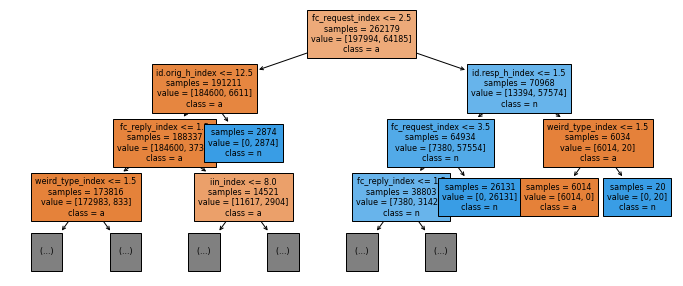

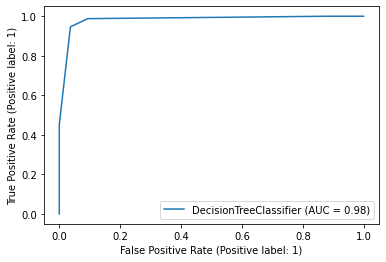

In [7]:
                                    # ENTRENAMIENTO Y EVALUACIÓN DEL MODELO 

dnp3_features = dnp3_df.drop(['anomaly', 'ts', 'uid', 'id.orig_h', 'id.resp_h', 
                           'fc_request', 'fc_reply', 'weird_type', 'iin', 
                           'id.resp_p', 'id.orig_p'], axis=1)

# Divide the Dataframe between "dnp3_train" and "dnp3_test"
dnp3_train, dnp3_test = train_test_split(dnp3_df, test_size=0.3, shuffle=True)

# Dividir los conjuntos de datos anteriores en X_train y_Train y en X_Test y_test
# X_train, y_train
X_train = dnp3_train.drop(['anomaly', 'ts', 'uid', 'id.orig_h', 'id.resp_h', 
                           'fc_request','fc_reply', 'weird_type', 'iin', 
                           'id.resp_p', 'id.orig_p'], axis=1)
y_train = dnp3_train['anomaly']

# X_test, y_test
X_test = dnp3_test.drop(['anomaly', 'ts', 'uid', 'id.orig_h', 'id.resp_h', 
                           'fc_request', 'fc_reply', 'weird_type', 'iin', 
                           'id.resp_p', 'id.orig_p'], axis=1)
y_test = dnp3_test['anomaly']


# Ahora tenemos que declarar nuestro clasificador "dt" que consisitirá en nuestro árbol de decisión
dt = DecisionTreeClassifier()

# Entrenamos nuesto arbol de decision
dt = dt.fit(X_train, y_train)

# Generamos nuestro y_pred
y_pred = dt.predict(X_test)

# Podemos representar visualmente el arbol que ha generado nuestro modelo. 
#Esto nos resultará muy útil para evaluar las características más importantes

fig, ax = plt.subplots(figsize=(12, 5))

plot = plot_tree(
            decision_tree = dt,
            feature_names = dnp3_features.columns,
            class_names   = 'anomaly',
            filled        = True,
            impurity      = False,
            fontsize      = 8,
            precision     = 2,
            ax            = ax, 
            max_depth     = 3
       )


# CALCULO DE MÉTRICAS OBJETIVAS 
# Tasa de Aciertos
acc = metrics.accuracy_score(y_test, y_pred)
# Puntuación f1
f1 = metrics.f1_score(y_test, y_pred, average='binary')

# Siempre antes de empezar a calcular las metricas del modelo, es importante obtener la matriz de confusión y entender cada valor

# Matriz de Confusión
confmat = metrics.confusion_matrix(y_test, y_pred)

# Calcular la tasa de Falsos positivos te permite conocer el porcentaje the instancias negativas se clasifica incorrectamente.
# Esta medida es muy últil a la hora de calcular la curva ROC.
fpr = (confmat[0,1]) / (confmat[0,1] + confmat[0,0])


# Curva ROC. Nos permite observar la comparación entre la Tasa de verdaderos positivos y falsos positivos
metrics.plot_roc_curve(dt, X_test, y_test)
auroc = metrics.roc_auc_score(y_test, y_pred)

>1, train: 0.924, test: 0.924
>2, train: 0.958, test: 0.957
>3, train: 0.958, test: 0.957
>4, train: 0.959, test: 0.959
>5, train: 0.959, test: 0.959
>6, train: 0.959, test: 0.959
>7, train: 0.959, test: 0.959
>8, train: 0.959, test: 0.959
>9, train: 0.959, test: 0.959


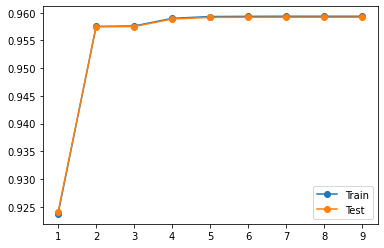

In [8]:
                                            # Evaluar "Overfitting" del Modelo

from matplotlib import pyplot
# Declarar lists para guardar los valores de accuracy
train_scores, test_scores = list(), list()
values = [i for i in range(1, 10)]
# El objetivo es crear un modelo por cada nivel de profundidad para observar su comportamiento
for i in values:
    # Creación del modelo
    model = DecisionTreeClassifier(max_depth=i)
    # Inyectar el conjunto de train para entrenar el modelo
    model.fit(X_train, y_train)
    
    # Evaluación  train dataset
    train_yhat = model.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    # Evaluación test dataset
    test_yhat = model.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # Visualizar Resultados
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
    
# Crear un histograma con la evolución
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

Feature: id.orig_h_index, Score: 0.070
Feature: id.resp_h_index, Score: 0.109
Feature: fc_request_index, Score: 0.801
Feature: fc_reply_index, Score: 0.016
Feature: weird_type_index, Score: 0.001
Feature: iin_index, Score: 0.003


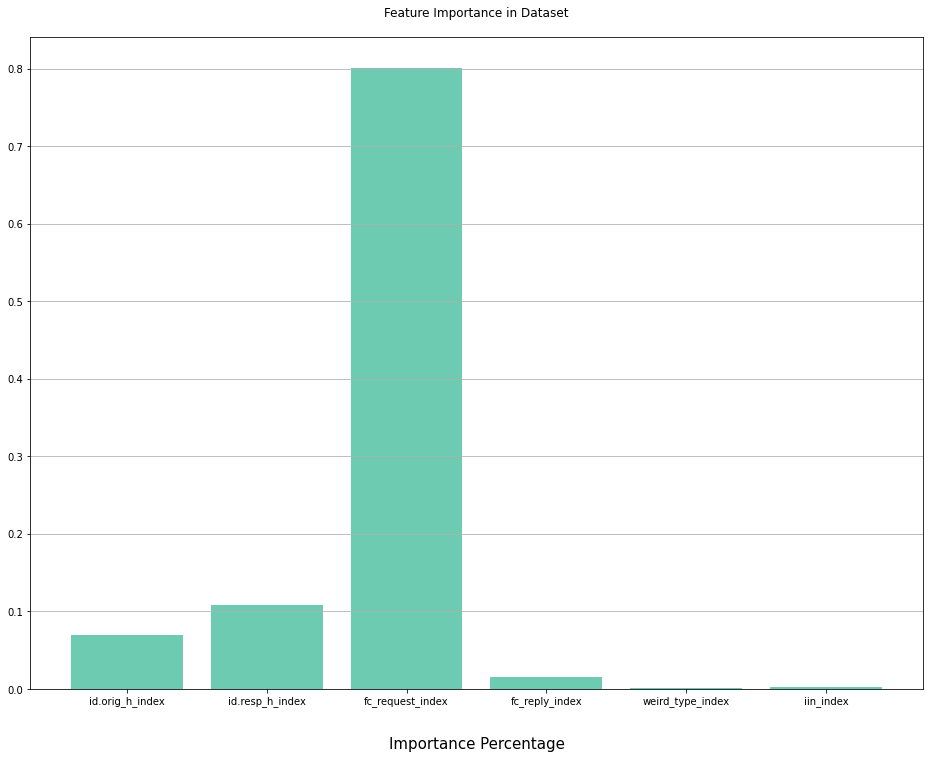

Profundidad del árbol: 7
Número de nodos terminales: 23



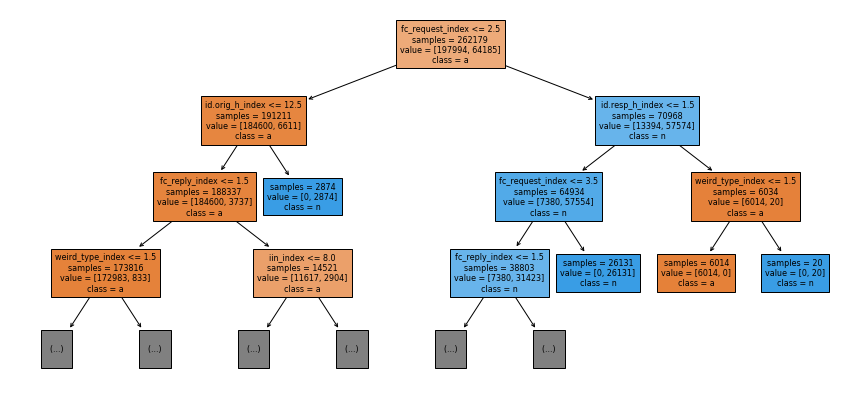

In [21]:
from matplotlib import pyplot

# Obtener importance
importance = dt.feature_importances_

labels=['id.orig_h_index','id.resp_h_index','fc_request_index','fc_reply_index',
      'weird_type_index', 'iin_index']
# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: {dnp3_features.columns[i]}, Score: %.3f' % (v))
    # plot feature importance
    pyplot.bar(dnp3_features.columns[i], v, color='#6ccbb0')

plt.xlabel("Importance Percentage", labelpad=30)
plt.rc('axes', labelsize=15) 
plt.title('Feature Importance in Dataset', pad=20)
pyplot.rcParams["figure.figsize"] = (16,12)
plt.grid(axis = 'y')
pyplot.show()

# Podemos representar visualmente el arbol que ha generado nuestro modelo. 
# Esto nos resultará muy útil para evaluar las características más importantes

fig, ax = plt.subplots(figsize=(15, 7))


print(f"Profundidad del árbol: {dt.get_depth()}")
print(f"Número de nodos terminales: {dt.get_n_leaves()}\n")

plot = plot_tree(
            decision_tree = dt,
            feature_names = dnp3_features.columns,
            class_names   = 'anomaly',
            filled        = True,
            impurity      = False,
            fontsize      = 8,
            precision     = 2,
            ax            = ax, 
            max_depth     = 3
       )

In [15]:
# Mostrar Métricas obtenidas
print(f"Matriz de Confusión:\n{confmat}\n")
print(f"Tasa de Aciertos Conjunto Test: {acc:.3f}\n")
print(f"Puntuación F1: {f1:.3f}\n")
print(f"Tasa de Falsos Positivos: {(confmat[1,0]) / (confmat[1,0] + confmat[0,0]):.3f}\n")
print(f"Precision: {metrics.precision_score(y_test, y_pred):.3f}")
print(f"AUC: {auroc:.2f}\n")
print(f"Recall: {metrics.recall_score(y_test, y_pred):.3f}\n")
confmat[0,1]

Matriz de Confusión:
[[82181  3117]
 [ 1470 25595]]

Tasa de Aciertos Conjunto Test: 0.959

Puntuación F1: 0.918

Tasa de Falsos Positivos: 0.018

Precision: 0.891
AUC: 0.95

Recall: 0.946



3117

## TEST UNDERFITTING

In [16]:
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

X = dnp3_features
y = dnp3_df['anomaly']
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

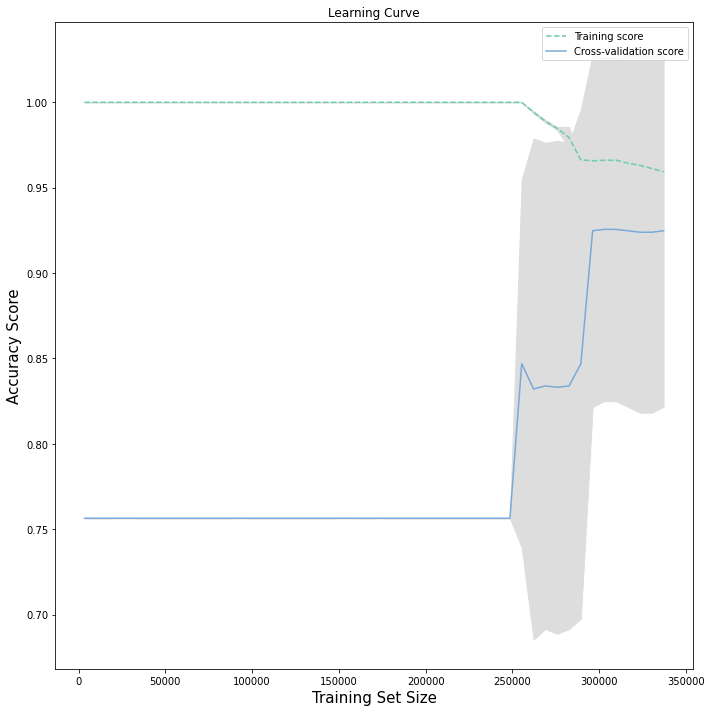

In [20]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#6ccbb0",  label="Training score")
plt.plot(train_sizes, test_mean, color="#78a9d8", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Balancear Modelo

Before: 0    198192
1     63987
Name: anomaly, dtype: int64

After: 0    198192
1    198192
Name: anomaly, dtype: int64

After: 0    85100
1    27263
Name: anomaly, dtype: int64



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


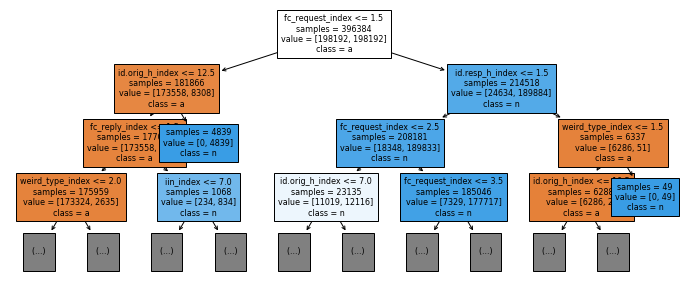

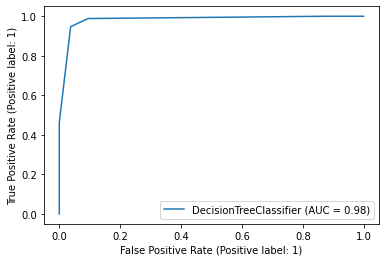

In [ ]:
test = dnp3_df


smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f'Before: {y_train.value_counts()}\n')
print(f'After: {y_resampled.value_counts()}\n')
print(f'After: {y_test.value_counts()}\n')


# Ahora tenemos que declarar nuestro clasificador "dt" que consisitirá en nuestro árbol de decisión
dt = DecisionTreeClassifier()

# Entrenamos nuesto arbol de decision
dt = dt.fit(X_resampled, y_resampled)

# Generamos nuestro y_pred
y_pred = dt.predict(X_test)

# Podemos representar visualmente el arbol que ha generado nuestro modelo. 
#Esto nos resultará muy útil para evaluar las características más importantes

fig, ax = plt.subplots(figsize=(12, 5))

plot = plot_tree(
            decision_tree = dt,
            feature_names = dnp3_features.columns,
            class_names   = 'anomaly',
            filled        = True,
            impurity      = False,
            fontsize      = 8,
            precision     = 2,
            ax            = ax, 
            max_depth     = 3
       )


# CALCULO DE MÉTRICAS OBJETIVAS 
# Tasa de Aciertos
acc = metrics.accuracy_score(y_test, y_pred)
# Puntuación f1
f1 = metrics.f1_score(y_test, y_pred, average='binary')

# Siempre antes de empezar a calcular las metricas del modelo, es importante obtener la matriz de confusión y entender cada valor

# Matriz de Confusión
confmat = metrics.confusion_matrix(y_test, y_pred)

# Calcular la tasa de Falsos positivos te permite conocer el porcentaje the instancias negativas se clasifica incorrectamente.
# Esta medida es muy últil a la hora de calcular la curva ROC.
fpr = (confmat[0,1]) / (confmat[0,1] + confmat[0,0])

# Curva ROC. Nos permite observar la comparación entre la Tasa de verdaderos positivos y falsos positivos
metrics.plot_roc_curve(dt, X_test, y_test)
auroc = metrics.roc_auc_score(y_test, y_pred)

>1, train: 0.917, test: 0.894
>2, train: 0.945, test: 0.925
>3, train: 0.946, test: 0.925
>4, train: 0.954, test: 0.957
>5, train: 0.954, test: 0.957
>6, train: 0.955, test: 0.958
>7, train: 0.955, test: 0.958
>8, train: 0.955, test: 0.958
>9, train: 0.955, test: 0.958


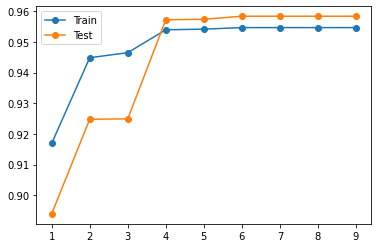

In [ ]:
                                            # Evaluar "Overfitting" del Modelo

from matplotlib import pyplot
# Declarar lists para guardar los valores de accuracy
train_scores, test_scores = list(), list()
values = [i for i in range(1, 10)]
# El objetivo es crear un modelo por cada nivel de profundidad para observar su comportamiento
for i in values:
    # Creación del modelo
    model = DecisionTreeClassifier(max_depth=i)
    # Inyectar el conjunto de train para entrenar el modelo
    model.fit(X_resampled, y_resampled)
    
    # Evaluación  train dataset
    train_yhat = model.predict(X_resampled)
    train_acc = metrics.accuracy_score(y_resampled, train_yhat)
    train_scores.append(train_acc)
    
    # Evaluación test dataset
    test_yhat = model.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # Visualizar Resultados
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
    
# Crear un histograma con la evolución
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

Feature: id.orig_h_index, Score: 0.067
Feature: id.resp_h_index, Score: 0.059
Feature: fc_request_index, Score: 0.863
Feature: fc_reply_index, Score: 0.008
Feature: weird_type_index, Score: 0.002
Feature: iin_index, Score: 0.001


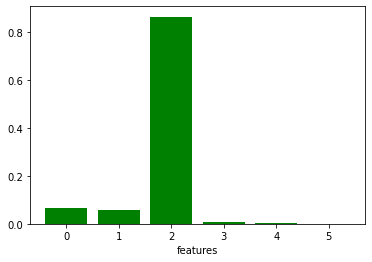

Profundidad del árbol: 7
Número de nodos terminales: 26



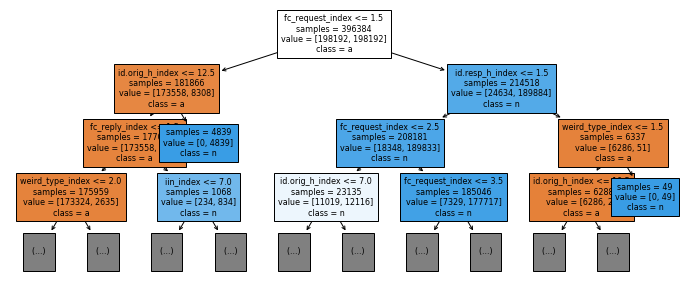

In [ ]:
from matplotlib import pyplot

# Obtener importance
importance = dt.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: {dnp3_features.columns[i]}, Score: %.3f' % (v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance, color='green')
plt.xlabel("features")
pyplot.show()

# Podemos representar visualmente el arbol que ha generado nuestro modelo. 
# Esto nos resultará muy útil para evaluar las características más importantes

fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {dt.get_depth()}")
print(f"Número de nodos terminales: {dt.get_n_leaves()}\n")

plot = plot_tree(
            decision_tree = dt,
            feature_names = dnp3_features.columns,
            class_names   = 'anomaly',
            filled        = True,
            impurity      = False,
            fontsize      = 8,
            precision     = 2,
            ax            = ax, 
            max_depth     = 3
       )

In [ ]:
# Mostrar Métricas obtenidas
print(f"Matriz de Confusión:\n{confmat}\n")
print(f"Tasa de Aciertos Conjunto Test: {acc:.3f}\n")
print(f"Puntuación F1: {f1:.3f}\n")
print(f"Tasa de Falsos Positivos: {fpr:3f}\n")
print(f"AUC: {auroc:.2f}\n")
print(f"Recall: {metrics.recall_score(y_test, y_pred)}\n")

Matriz de Confusión:
[[81801  3066]
 [ 1526 25970]]

Tasa de Aciertos Conjunto Test: 0.959

Puntuación F1: 0.919

Tasa de Falsos Positivos: 0.036127

AUC: 0.95

Recall: 0.9445010183299389



# Evaluation of Machine Leanring Algorithms


## Find Best K for KNN 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
error_rate=[]#list that will store the average error rate value of k
for i in range (1,31):  #Took the range of k from 1 to 30
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train, y_train)
    predict_i = clf.predict(X_test)
    error_rate.append(np.mean(predict_i != y_test))
error_rate

[0.041321431432055036,
 0.04085864563957887,
 0.04085864563957887,
 0.04085864563957887,
 0.040849745912800474,
 0.04084084618602209,
 0.040849745912800474,
 0.04087644509313564,
 0.04088534481991403,
 0.04088534481991403,
 0.04088534481991403,
 0.04089424454669242,
 0.04089424454669242,
 0.04091204400024919,
 0.04092094372702758,
 0.04092094372702758,
 0.04091204400024919,
 0.04092094372702758,
 0.04091204400024919,
 0.04091204400024919,
 0.04091204400024919,
 0.04092094372702758,
 0.04092094372702758,
 0.04092094372702758,
 0.04092094372702758,
 0.04092094372702758,
 0.04091204400024919,
 0.04091204400024919,
 0.04091204400024919,
 0.04091204400024919]

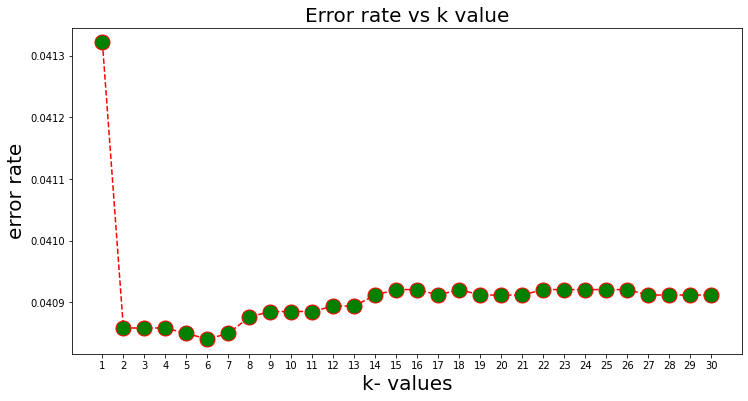

In [ ]:
#plotting the error rate vs k graph 
plt.figure(figsize = (12,6))
plt.plot(range(1,31), error_rate,marker = "o", markerfacecolor="green",
         linestyle = "dashed",color = "red", markersize=15)
plt.title("Error rate vs k value", fontsize = 20)
plt.xlabel("k- values", fontsize = 20)
plt.ylabel("error rate", fontsize = 20)
plt.xticks(range(1, 31))
plt.show()

## Train Models

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC


# Para realizar una comparativa de modelos, tenemos que realizar una division de entrenamiento-validacion y test.
# Antes de realizar la división, crearemos un "diccionario" para guardar los modelos con los que vamos a trabajar

classifiers = { 
    'DecTree' : (DecisionTreeClassifier, {
        'criterion' : ['gini', 'entropy'],
        'splitter' : ['best', 'random'],
        'random_state' : [0],
    } ),
    'RandForest' : (RandomForestClassifier, {
        'criterion' : ['gini', 'entropy', 'log_loss'],
        'random_state' : [0],
        'max_depth' : [5, 7]
    } ),
    'MLP' : (MLPClassifier, {
        'hidden_layer_sizes' : [(128,), (64,64), (64, 32, 16)],
        'activation': ['relu', 'tanh'],
    }),    
    'KNN' : (KNeighborsClassifier, {
        'n_neighbors' : [6, 7],
        'p' : [1, 2, 3],
    } ),
    'SVC' : (SVC, {
        'kernel' : ['sigmoid'],
        'gamma' : ['auto'],
        'random_state' : [0],
    } ),
}

In [ ]:
import itertools
from sklearn.model_selection import KFold

X = dnp3_features
y = dnp3_df['anomaly']

# Instanciamos una clase para hacer validación cruzada con 5 hojas
Xv, yv = X.values, y.values
cv = KFold(n_splits = 5, shuffle=True)

# Inicializamos una lista vacía para almacenar los resultados
results = []

# Iteramos por los distintos clasificadores
for clf_name, clf_info in classifiers.items():
  clf_class, clf_hyperparams = clf_info  
  hyp_ks, hyp_vs = clf_hyperparams.keys(), clf_hyperparams.values()
  configs = [dict(zip(hyp_ks, v)) for v in itertools.product(*hyp_vs)]

  # Iteramos por las distintas configuraciones de hiperparámetros
  for config in configs:
    print(config)
    # Instanciamos el clasificador con los hiperparámetros escogidos
    try:
      clf = clf_class(**config)
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      confmat = metrics.confusion_matrix(y_test, y_pred)
      results.append({
          'Classifier': clf_name,
          'Hyperparameter' : str(config),
          'Accuracy' : metrics.accuracy_score(y_test, y_pred),
          'Precision' : metrics.precision_score(y_test, y_pred),
          'Recall' : metrics.recall_score(y_test, y_pred),
          'FPR' : (confmat[0,1] / (confmat[0,1] + confmat[0,0])),
          'F1' : metrics.f1_score(y_test, y_pred, average='binary'),
      })
    except Exception as e:
      pass

{'n_neighbors': 6, 'p': 1}
{'n_neighbors': 6, 'p': 2}
{'n_neighbors': 6, 'p': 3}
{'n_neighbors': 7, 'p': 1}
{'n_neighbors': 7, 'p': 2}
{'n_neighbors': 7, 'p': 3}
{'kernel': 'sigmoid', 'gamma': 'auto', 'random_state': 0}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
results_model = pd.DataFrame(results)
results_model.to_csv("results_model.csv", index=False)

## Evaluation of Results

In [5]:
results_model = pd.read_csv('results_model.csv')
results_model

,Classifier,Hyperparameter,Accuracy,Precision,Recall,FPR,F1
0,DecTree,"{'criterion': 'gini', 'splitter': 'best', 'ran...",0.959177,0.891439,0.945686,0.036542,0.917762
1,DecTree,"{'criterion': 'gini', 'splitter': 'random', 'r...",0.959168,0.891408,0.945686,0.036554,0.917745
2,DecTree,"{'criterion': 'entropy', 'splitter': 'best', '...",0.959177,0.891439,0.945686,0.036542,0.917762
3,DecTree,"{'criterion': 'entropy', 'splitter': 'random',...",0.959177,0.891439,0.945686,0.036542,0.917762
4,RandForest,"{'criterion': 'gini', 'random_state': 0, 'max_...",0.959177,0.891439,0.945686,0.036542,0.917762
5,RandForest,"{'criterion': 'entropy', 'random_state': 0, 'm...",0.959177,0.891439,0.945686,0.036542,0.917762
6,MLP,"{'hidden_layer_sizes': (128,), 'activation': '...",0.959168,0.891408,0.945686,0.036554,0.917745
7,MLP,"{'hidden_layer_sizes': (128,), 'activation': '...",0.959132,0.891366,0.945575,0.036566,0.917671
8,MLP,"{'hidden_layer_sizes': (64, 64), 'activation':...",0.958216,0.888099,0.945686,0.037809,0.915988
9,MLP,"{'hidden_layer_sizes': (64, 64), 'activation':...",0.959177,0.891439,0.945686,0.036542,0.917762


In [25]:
# Build a multi bar chart about Decision Tree
# It will represent the value of each metric.
new_df = pd.DataFrame()
new_df = results_model.iloc[[2, 5, 9, 10, 19, 12]]

In [26]:
new_df.reset_index(inplace = True, drop = True)
new_df

,Classifier,Hyperparameter,Accuracy,Precision,Recall,FPR,F1
0,DecTree,"{'criterion': 'entropy', 'splitter': 'best', '...",0.959177,0.891439,0.945686,0.036542,0.917762
1,RandForest,"{'criterion': 'entropy', 'random_state': 0, 'm...",0.959177,0.891439,0.945686,0.036542,0.917762
2,MLP,"{'hidden_layer_sizes': (64, 64), 'activation':...",0.959177,0.891439,0.945686,0.036542,0.917762
3,MLP,"{'hidden_layer_sizes': (64, 32, 16), 'activati...",0.959177,0.891439,0.945686,0.036542,0.917762
4,KNN,"{'n_neighbors': 6, 'p': 2}",0.959159,0.891432,0.945612,0.036542,0.917723
5,SVC,"{'kernel': 'rbf', 'gamma': 'scale', 'random_st...",0.959168,0.891408,0.945686,0.036554,0.917745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_container0' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_container1' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_container2' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_container3' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_container4' which cannot be automatically a

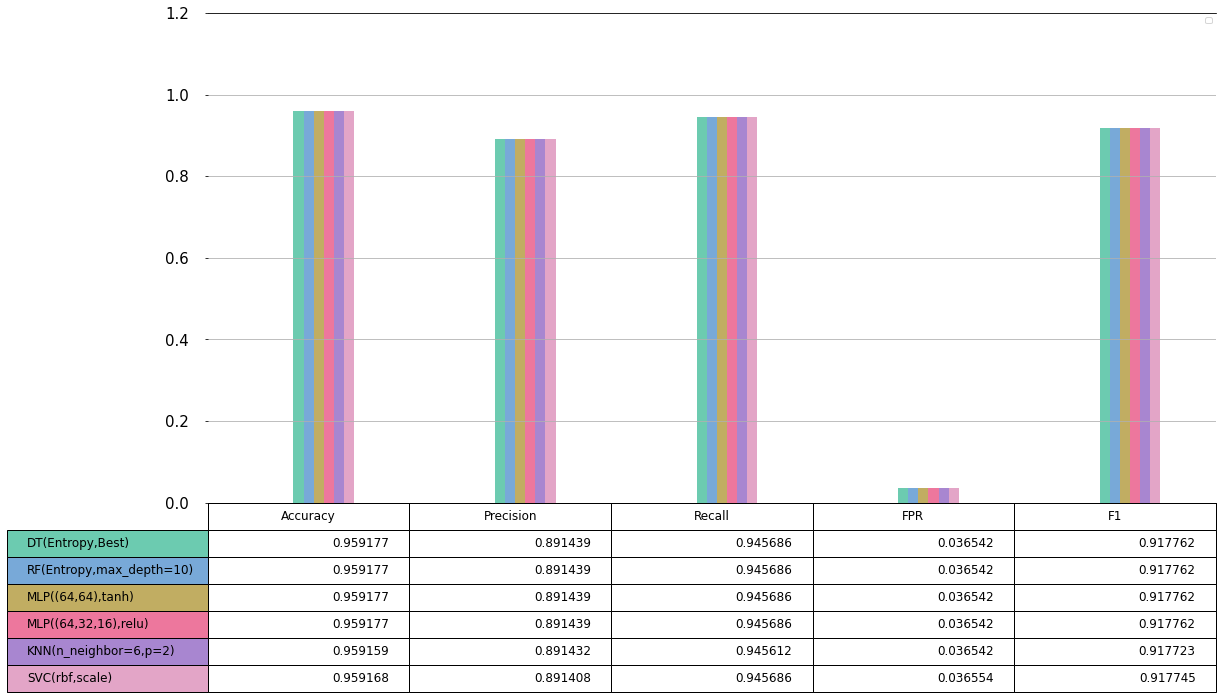

In [15]:
# Implementation of matplotlib function
import numpy as np
import matplotlib.pyplot as plt

#define figure size in (width, height) for all plots
#plt.rcParams['figure.figsize'] = [10, 7]
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

def plot_bar(dataset):
    matplotlib.rc('font', family='sans-serif')
    matplotlib.rc('font', serif='Helvetica Neue')
    matplotlib.rc('text', usetex='false')
    matplotlib.rcParams.update({'font.size': 8})
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(20,10)
    N = len(dataset[1])

    Load    = dataset[0]
    DT     = dataset[1]
    RF  = dataset[2]
    MLP = dataset[3]
    MLP1 = dataset[4]
    KNN = dataset[5]
    SVC = dataset[6]

    ind = np.arange(N)
    width = 0.05
    spare_width = (1 - width*2)/2


    plt.tick_params(axis='both', which='major', labelsize=15, pad=15)
    plt.tick_params(axis='y', which='minor', labelsize=15, pad=15)


    rects1 = ax.bar(ind, DT, width,
                color='#6ccbb0',
                )

    rects3 = ax.bar(ind+width, RF, width,
                color='#78a9d8',
                )
    
    rects5 = ax.bar(ind+2*width, MLP, width,
                color='#c1ad62',
                )
    
    rects7 = ax.bar(ind+3*width, MLP1, width,
                color='#ed779d',
                )
    
    rects9 = ax.bar(ind+4*width, KNN, width,
                color='#a886d0',
                )
    
    rects11 = ax.bar(ind+5*width, SVC, width,
                color='#e3a5c7',
                )

    lns = [rects1, rects3, rects5, rects7, rects9, rects11]
    labs = [l.get_label() for l in lns]

    ax.legend(lns, labs, ncol=2)

    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_visible(False)


    ax.set_xlim(-spare_width,len(ind)-spare_width)
    ax.set_ylim(0, 1.2)

    xTickMarks = dataset[0]
    ax.set_xticks(ind+width)
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=0, fontsize=40)
    plt.xticks([])
    ax.yaxis.grid()

    cell_text = [[0.959177,	0.891439,	0.945686,	0.036542,	0.917762], 
                 [0.959177,	0.891439,	0.945686,	0.036542,	0.917762], 
                 [0.959177,	0.891439,	0.945686,	0.036542,	0.917762],
                 [0.959177,	0.891439,	0.945686,	0.036542,	0.917762],
                 [0.959159,	0.891432,	0.945612,	0.036542,	0.917723],
                 [0.959168,	0.891408,	0.945686,	0.036554,	0.917745]]

    colors=['#6ccbb0', '#78a9d8', '#c1ad62', '#ed779d', '#a886d0', '#e3a5c7',]
    rows = ['DT(Entropy,Best)','RF(Entropy,max_depth=10)', 'MLP((64,64),tanh)', 
            'MLP((64,32,16),relu)', 'KNN(n_neighbor=6,p=2)', 'SVC(rbf,scale)' ]
    Loc='right'
    # #ffe5b1
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          colLabels=Load,
                          rowColours=colors,
                          cellLoc='right',
                          loc='bottom')
    the_table.scale(1,2.5)

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    plt.subplots_adjust(left=0.2, bottom=0.2)

    ax.xaxis.labelpad = 70

    ax.yaxis.labelpad = 20
    fig.savefig('rps-watt' +'.eps',format='eps',bbox_inches='tight', pad_inches=0.1, dpi=1000)

dataset = [['Accuracy', 'Precision', 'Recall', 'FPR', 'F1'],
          [0.959177,	0.891439,	0.945686,	0.036542,	0.917762], 
          [0.959177,	0.891439,	0.945686,	0.036542,	0.917762], 
          [0.959177,	0.891439,	0.945686,	0.036542,	0.917762],
          [0.959177,	0.891439,	0.945686,	0.036542,	0.917762],
          [0.959159,	0.891432,	0.945612,	0.036542,	0.917723],
          [0.959168,	0.891408,	0.945686,	0.036554,	0.917745]]
plot_bar(dataset)
